In [83]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,io,sys,glob, h5py, csv, time
import matplotlib.pyplot as plt
import json

from dlab import generalephys as ephys
from dlab import generalephys_mua as ephys_mua
#from neuropixels import cell_pairs as pairs

#from neuropixels import utils_pipeline as utils
#from neuropixels import analysis_pipeline as analysis

from dlab import analysis_pipeline as analysis
from dlab.continuous_traces import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import pearsonr, spearmanr, zscore
from itertools import combinations 
#from neuropixels import sorting_quality_editing as sq
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans2
#from dlab import depth_estimation as depth
#from dlab import PCA as pca
from scipy import stats
from dlab.continuous_traces import gaussian_filter1d


import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# some functions

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def countlist(lst): #to count consecutive numbers in movement-related code
    streak_count = []
    inds = []
    ups = []
    downs = []
    counter = 1
    for i in range(len(lst)):
        if i != (len(lst) - 1):
            diff = lst[i+1] - lst[i]
            if diff == 1:
                counter += 1
                inds.append(lst[i])
            else:
                streak_count.append(counter)
                counter = 1
                if inds!=[]:
                    ups.append(np.min(inds))
                    downs.append(np.max(inds))
                    inds = []
        else:
            streak_count.append(counter)
    return(streak_count,ups,downs)

# load files

In [85]:
file1 = r'C:\Users\Kim\Desktop\suite2prun\suite2p\plane0\F.npy'
file2 = r'C:\Users\Kim\Desktop\suite2prun\suite2p\plane0\iscell.npy'
file3 = r'Z:\BIOElectricsLab\crystal\TSeries-01102021-1251_crystal_12-361\TSeries-01102021-1251_crystal_12-361_Cycle00001_VoltageRecording_001.csv'

In [4]:
stim = pd.read_csv(file3)

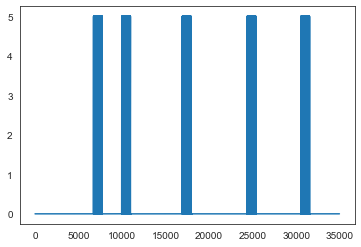

In [5]:
plt.plot(np.array(stim.Time),np.array(stim.Stim)) # if this doesn't work then open .csv file and change column titles to Time and Stim

In [86]:
flu = np.load(file1)
cells = np.load(file2)

In [87]:
np.shape(cells)

(5015, 2)

In [88]:
# creates list of "good" axon ROIs that we chose in suite2p
# iscells.npy is a list of cells (1) and not cells (0) as classified in suite2p, this loop makes list of only cells, called axons
axons = []
for i,cell in enumerate(cells):
    if cell[0]<0:
        axons.append(flu[i])

In [89]:
np.shape(axons)[1] # number of frames

500

In [92]:
time = np.arange(0,500/15,1/15) # make an array from 0 to frames/framerate with steps of 1/framerate

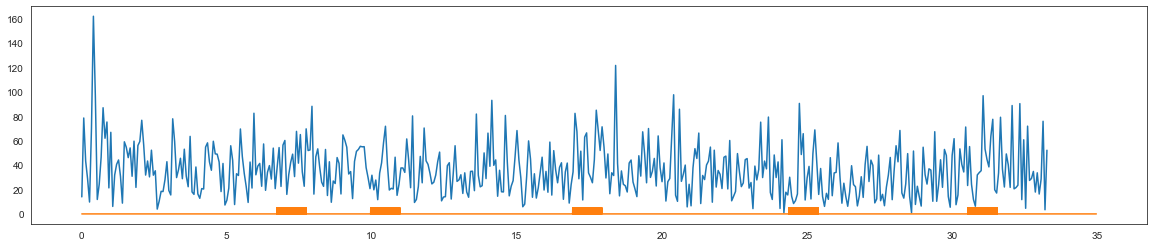

In [93]:
# plot individual axon ROIs
plot_ = axons[1] # interate through axons 
plt.subplots(figsize=(20,4))
plt.plot(time[:-1],plot_)
plt.plot(stim.Time/1000,stim.Stim)
#plt.savefig('path/fig.svg') # save this fig as .svg to your designated path

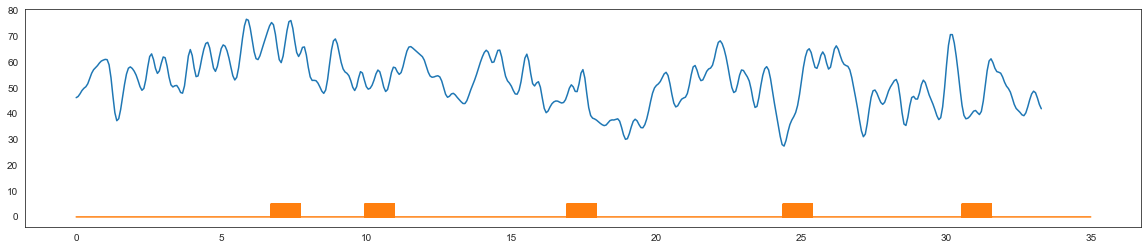

In [106]:
# plot average ROIs
for i in axons[:1]:
    #plot_ = np.mean(axons,axis=0)
    plt.subplots(figsize=(20,4))
    plt.plot(time[:-1],gaussian_filter1d(i,sigma=2))
    plt.plot(stim.Time/1000,stim.Stim)
    plt.savefig(r'C:\Users\Kim\Desktop\suite2prun\figs\axon.svg')

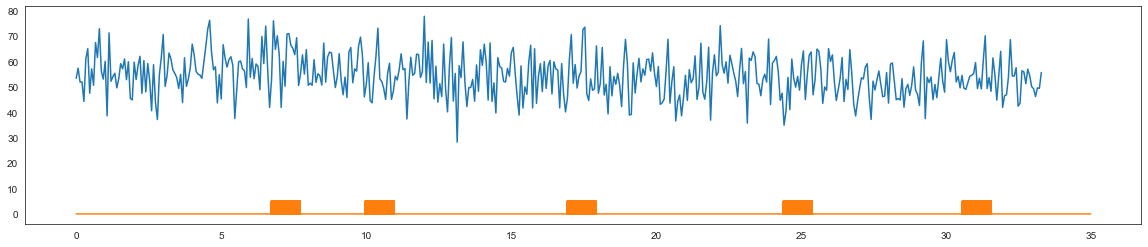

In [105]:
plot_ = np.mean(axons[:10],axis=0)
plt.subplots(figsize=(20,4))
plt.plot(time[:-1],plot_)
plt.plot(stim.Time/1000,stim.Stim)
plt.savefig(r'C:\Users\Kim\Desktop\suite2prun\figs\axon.svg')

# ignore below

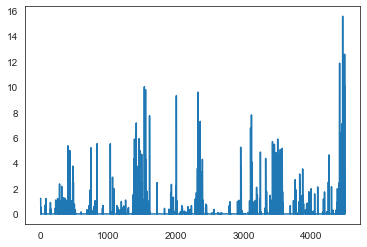

In [379]:
plt.plot(axons[50])

# "synch" time for axons and movement

In [10]:
#convert to time
total_time = (1/8*np.shape(axons[0])[0])
FR = 1/8 #sampling rate of 2P
t_axons = np.arange(0,total_time,FR)

In [11]:
#convert to time
total_time = np.shape(move)[0]*(1/42)
FR = 1/42 # sampling rate of arduino
t_move = np.arange(0,total_time,FR)

In [12]:
move_diff = np.diff(move)

(23770,)

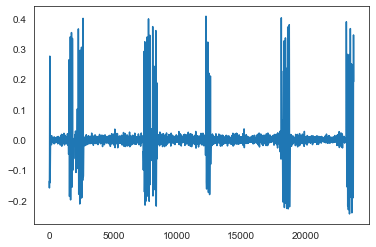

In [13]:
smooth_move = gaussian_filter1d(move_diff, sigma=8)
plt.plot(smooth_move)
np.shape(smooth_move)

# didnt use this stuff

NameError: name 't_ups' is not defined

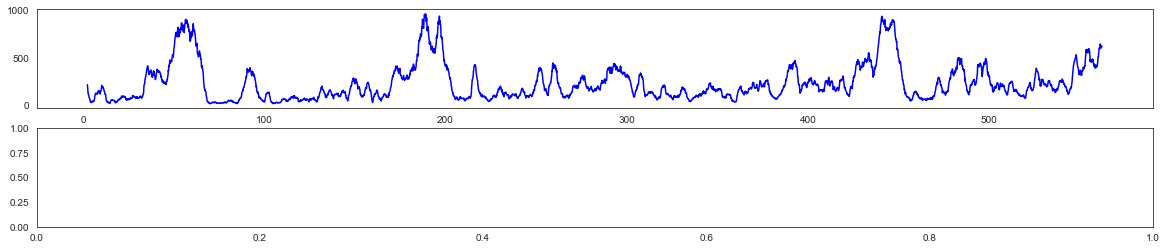

In [15]:
for i,axon in enumerate(axons):
    unit_ser = pd.Series(axon)
    rolave_unit = unit_ser.rolling(20).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
    rolave_unit = np.array(rolave_unit.dropna())
    #olave_unit = gaussian_filter1d(rolave_unit, sigma=3)
    mn = np.mean(rolave_unit)
    std = np.std(rolave_unit)
    thresh = mn+(1*std)
    smooth_move = gaussian_filter1d(move_diff, sigma=8)
    fig,(ax1,ax2) = plt.subplots(2,figsize=(20,4))
    ax1.plot(t_axons[19:],rolave_unit,c='b')
    for j in t_ups:
        j = find_nearest(t_axons,j)
        ax1.axvline(j,c='gray')
    ax2.plot(smooth_move[1:],c='r')
    plt.title(i)
    file = r'Z:\BIOElectricsLab\Katie\motionexpday1_072022\367'
    #plt.savefig(os.path.join(file,'axon'+str(i)+'.pdf'))
    plt.show()
    plt.close()

# find movement epochs

(array([    0,     1,     2, ..., 23718, 23719, 23720], dtype=int64),)
[0, 1525, 2386, 7353, 8030, 8187, 12151, 18036, 18216]


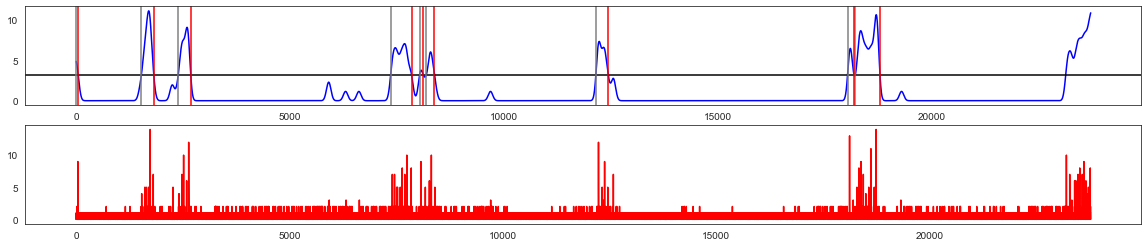

In [55]:
unit_ser = pd.Series(gaussian_filter1d(mv,sigma=50))
#smoothed_move = pd.Series(gaussian_filter1d(mv,sigma=1))
rolave_unit = unit_ser.rolling(50).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
rolave_unit = np.array(rolave_unit.dropna())
#rolave_unit = gaussian_filter1d(rolave_unit, sigma=3)
mn = np.mean(rolave_unit)
std = np.std(rolave_unit)
thresh = mn+std
cross = np.where(rolave_unit>thresh)
print(cross)
streaks,ups,downs = countlist(cross[0])
fig,(ax1,ax2) = plt.subplots(2,figsize=(20,4))
ax1.plot(rolave_unit,c='b')
ax2.plot(np.abs(np.diff(move)),c='r')
ax1.axhline(thresh,c='black')
print(ups)
for v in ups:
    ax1.axvline(v,c='gray')
for d in downs:
    ax1.axvline(d,c='r')

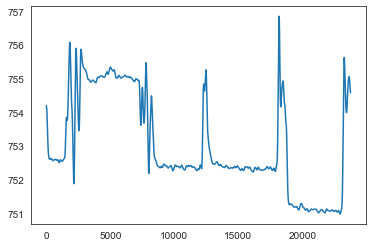

In [53]:
smoothed_move = pd.Series(gaussian_filter1d(move,sigma=50))
plt.plot(smoothed_move)

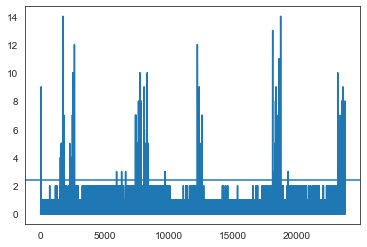

In [50]:
move_fix = np.abs(np.diff(move))
plt.plot(np.abs(np.diff(move)))
mn = np.mean(np.abs(np.diff(move)))
std = np.std(np.abs(np.diff(move)))
thresh = mn+(3*std)
plt.axhline(thresh)
mv = []
for i in move_fix:
    if i>thresh:
        mv.append(i)
    else:
        mv.append(0)

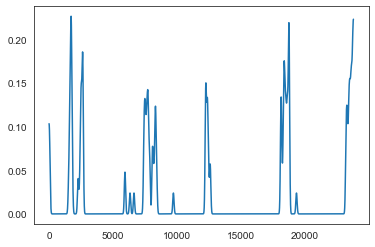

In [34]:
a = gaussian_filter1d(mv,sigma=50)
plt.plot(a)
for j in ups:
    plt.axvline(j,c='red')

In [33]:
# convert to axon time
t_ups = t_move[ups]
up_move = []
for t in t_ups:
    t_a = find_nearest(t_axons,t)
    this = np.where(t_axons==t_a)
    this = this[0][0]
    up_move.append(this)

In [26]:
# convert to axon time
t_downs = t_move[downs]
down_move = []
for t in t_downs:
    t_a = find_nearest(t_axons,t)
    this = np.where(t_axons==t_a)
    this = this[0][0]
    down_move.append(this)

# normalize fluorescence

In [27]:
dfs = []
for i,axon in enumerate(axons):
    fmin = np.min(axon)
    fmax = np.max(axon)
    df = (axon-fmin)/fmax # this is a shitty way to normalize but good enough for now
    #mn = np.mean(axons[i])
    #df = (axon-mn)/mn
    dfs.append(df)

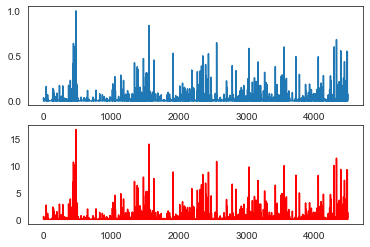

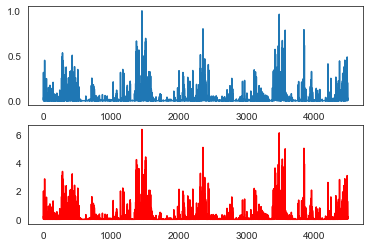

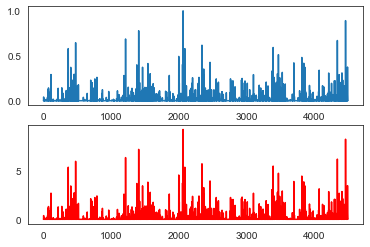

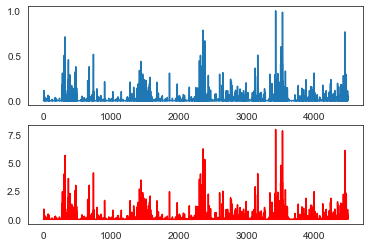

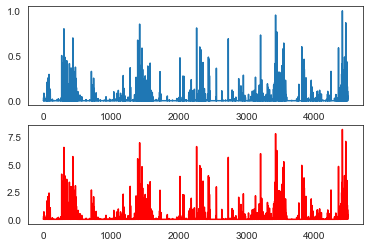

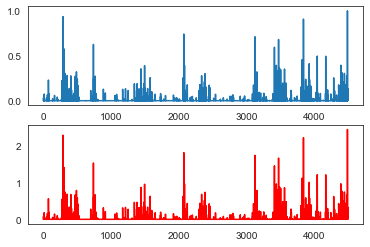

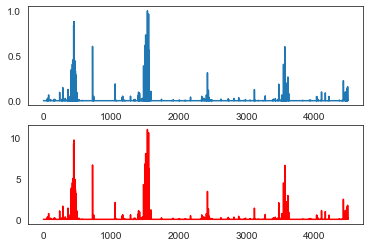

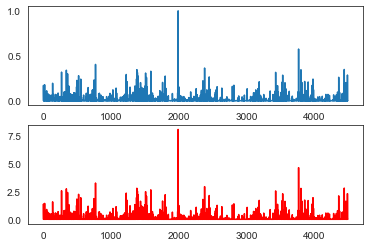

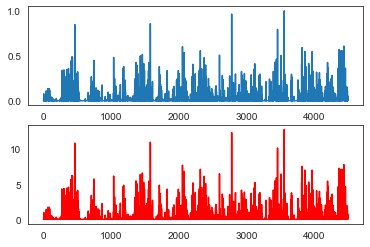

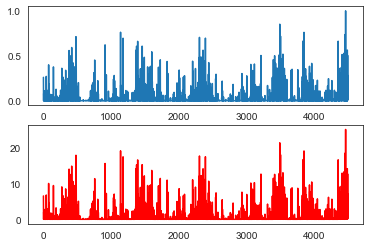

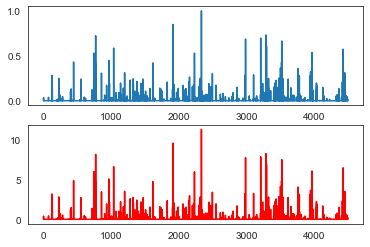

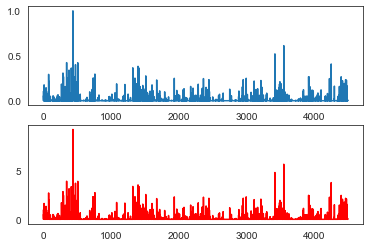

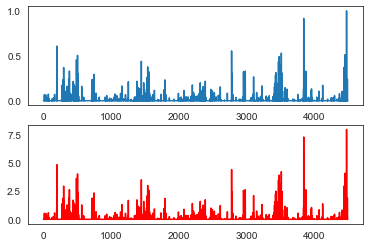

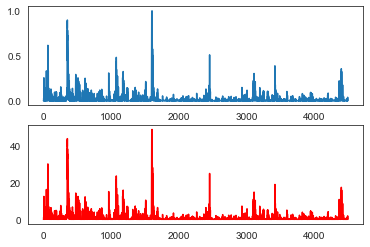

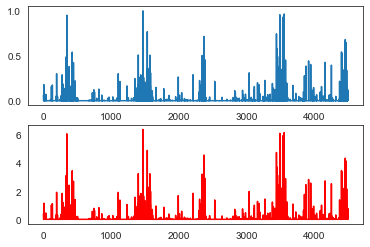

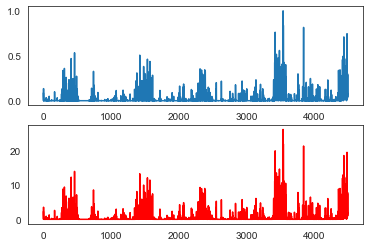

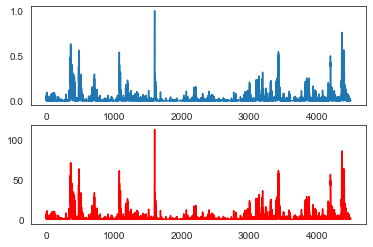

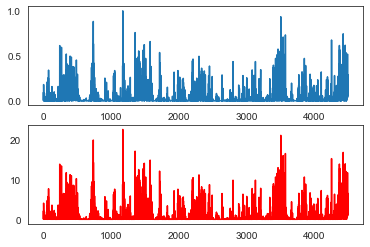

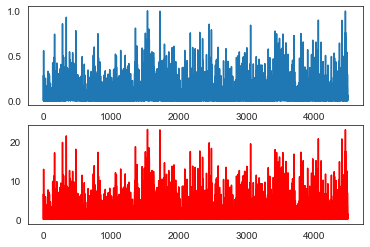

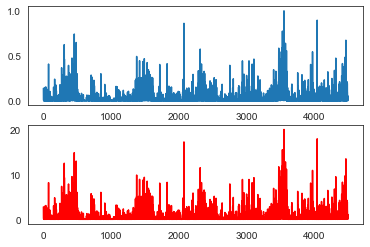

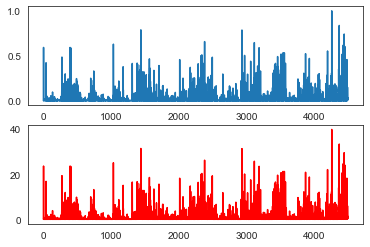

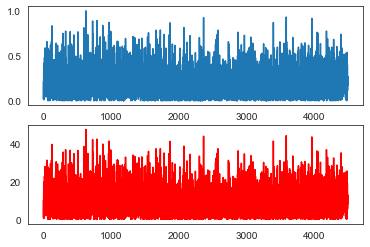

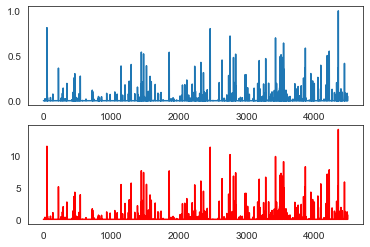

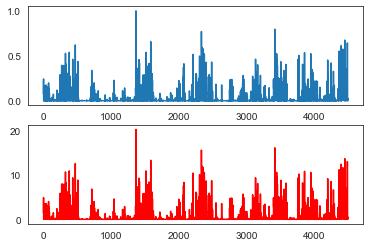

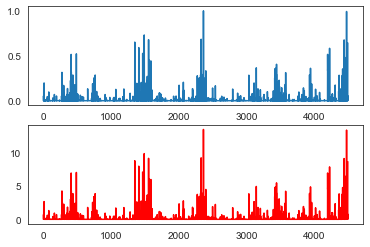

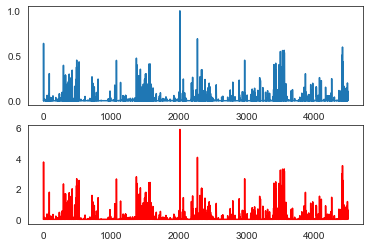

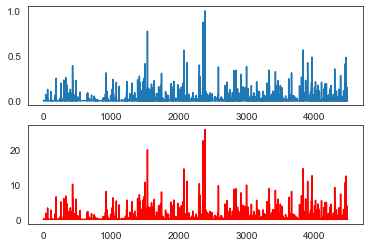

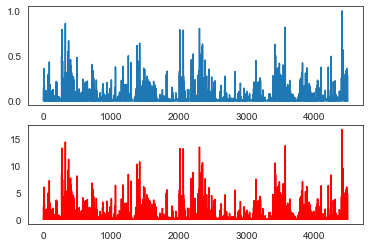

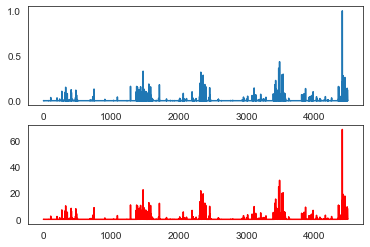

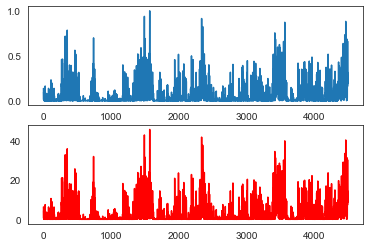

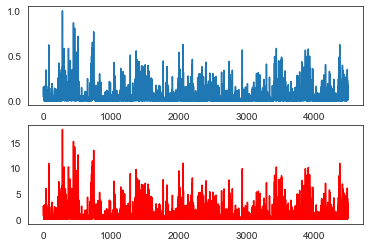

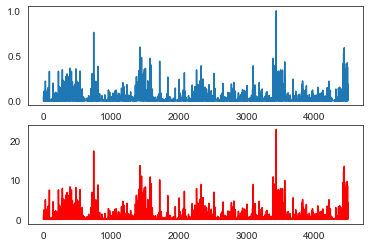

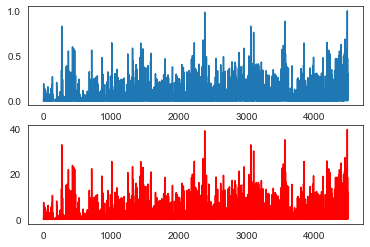

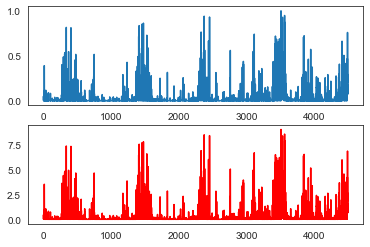

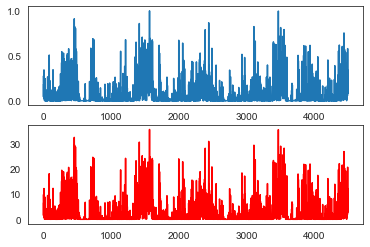

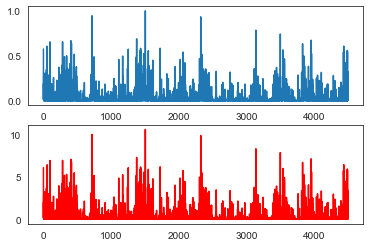

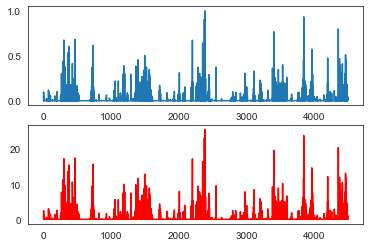

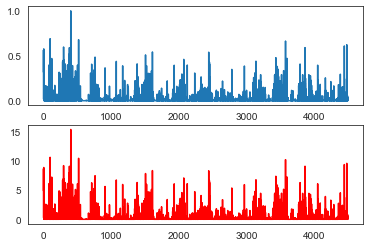

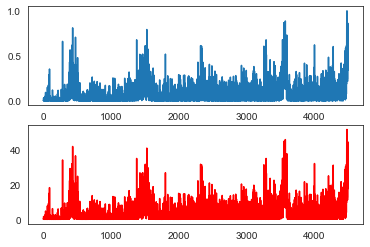

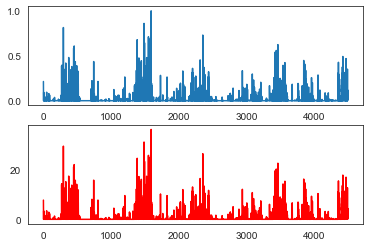

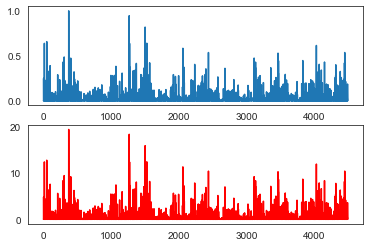

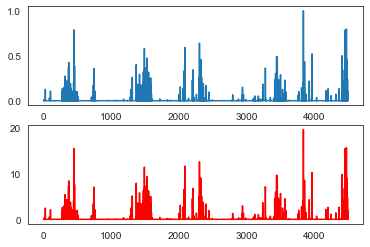

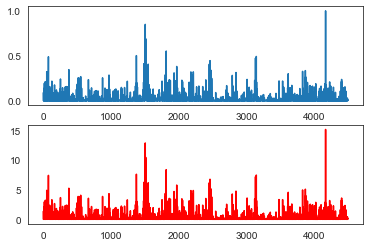

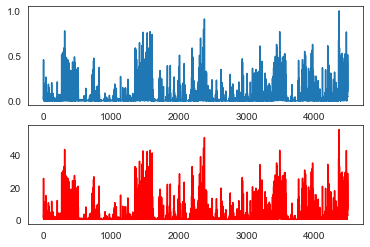

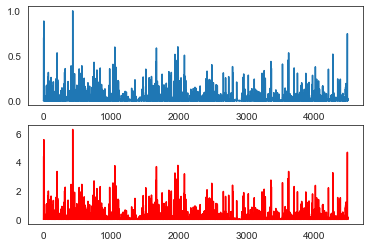

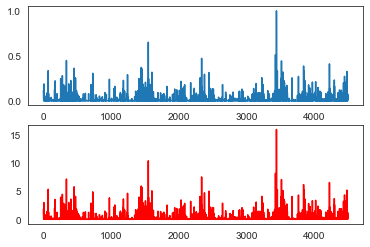

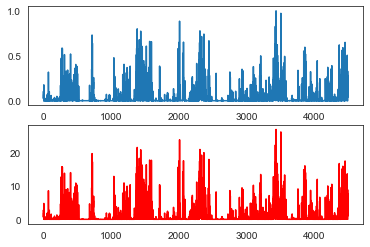

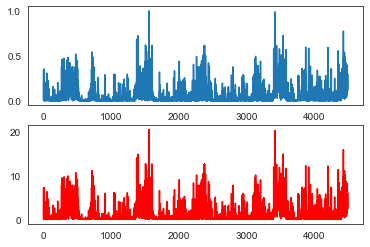

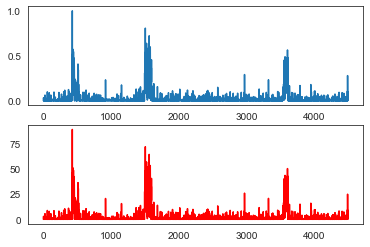

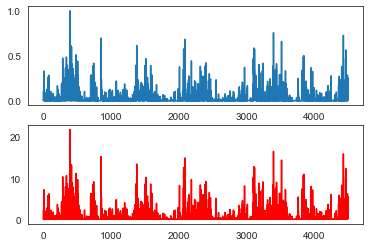

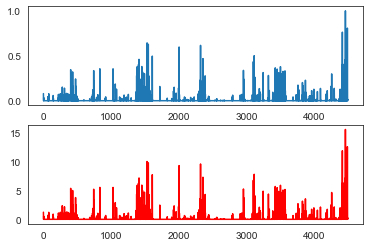

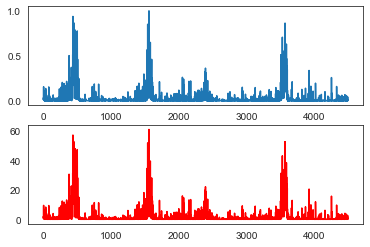

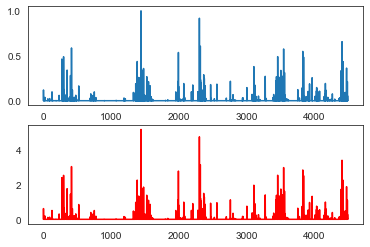

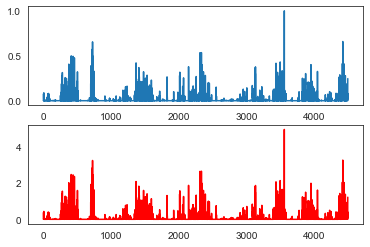

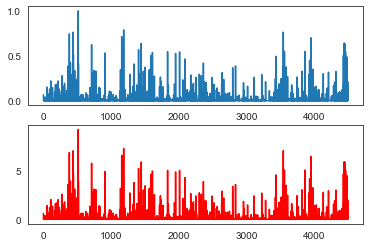

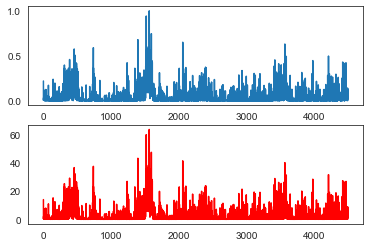

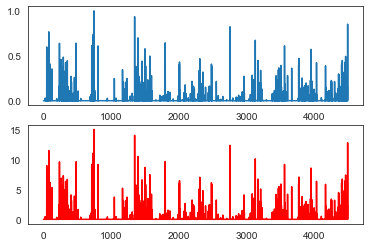

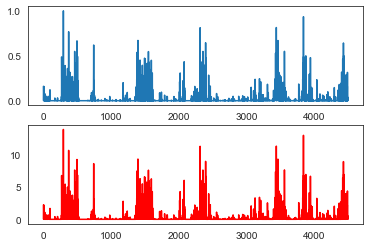

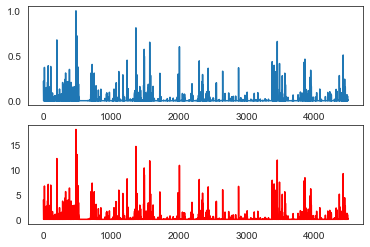

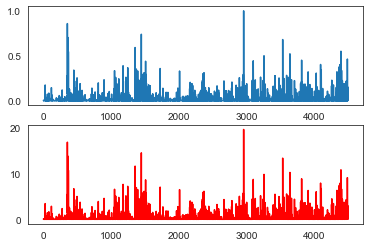

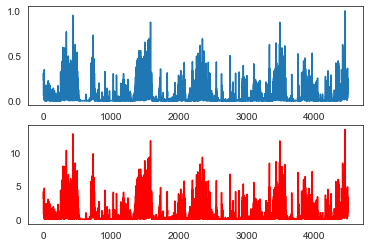

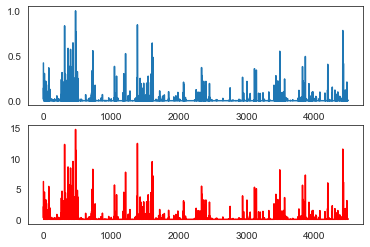

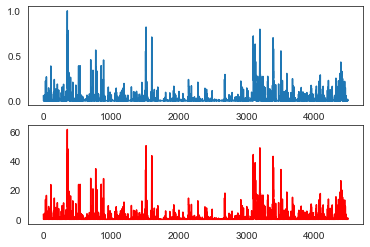

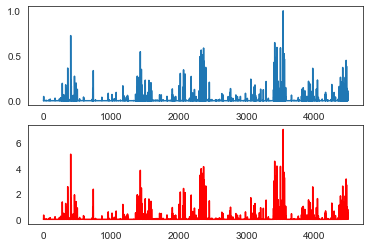

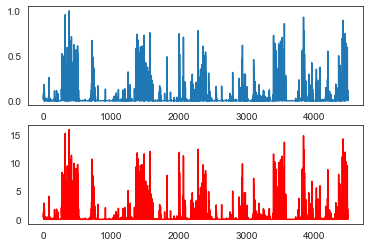

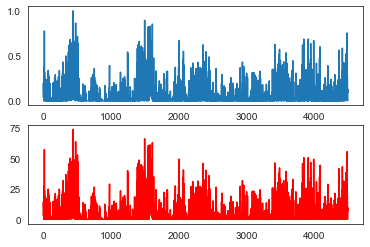

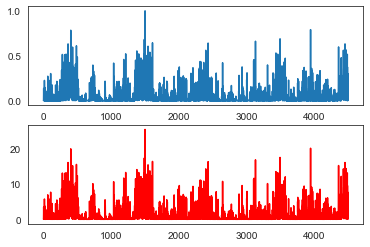

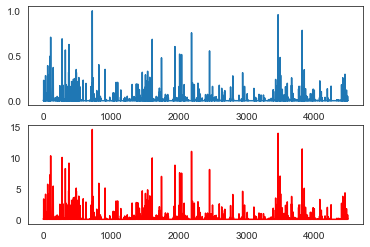

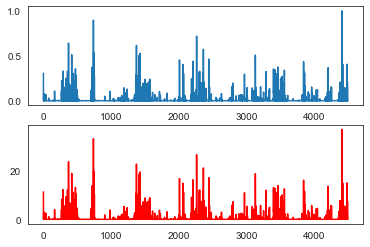

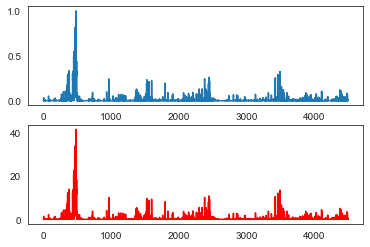

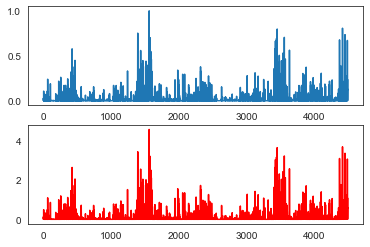

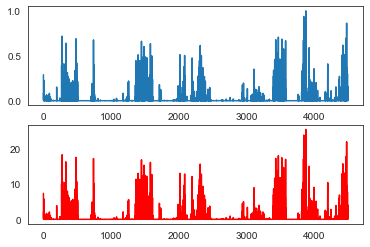

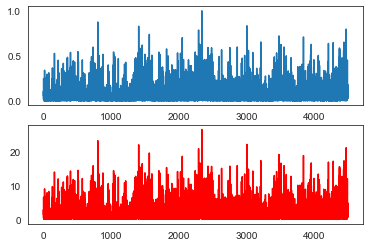

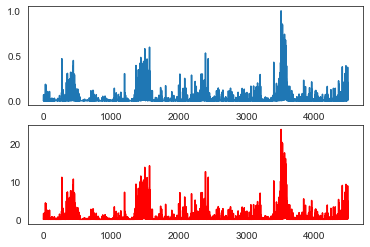

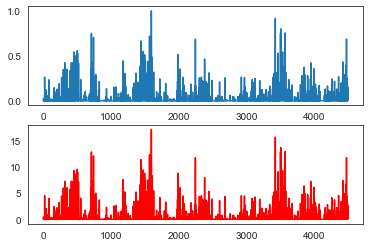

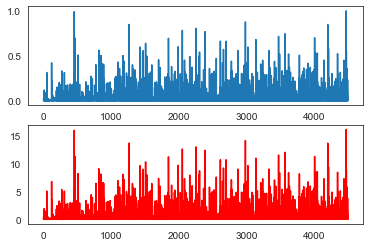

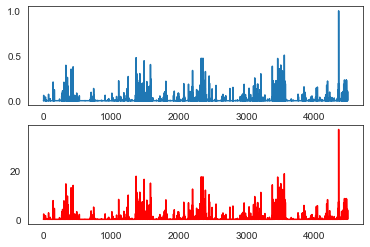

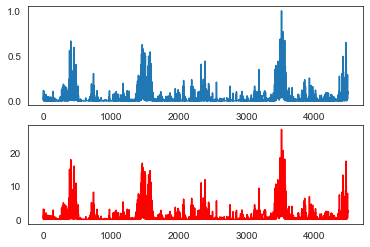

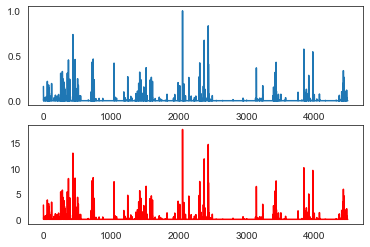

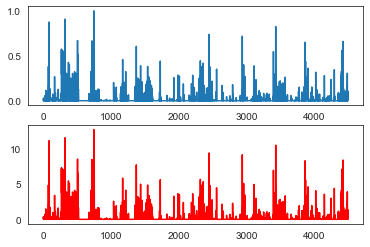

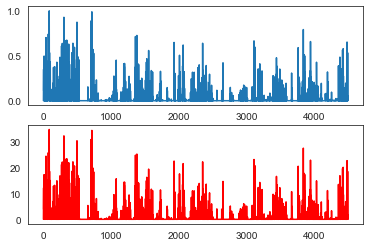

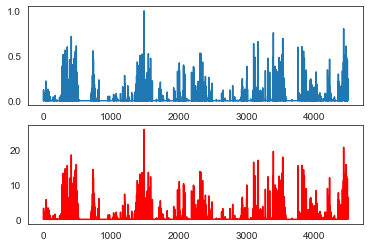

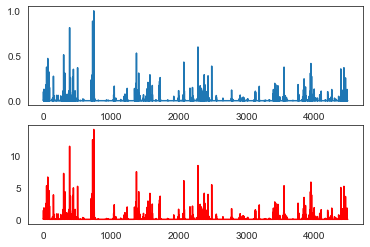

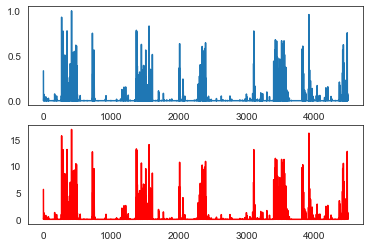

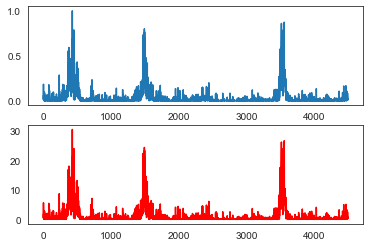

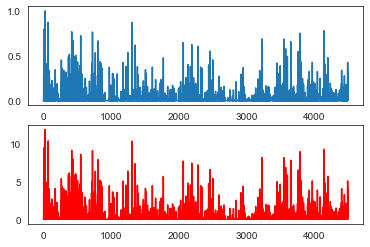

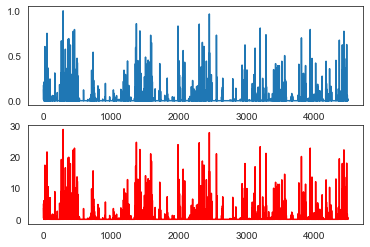

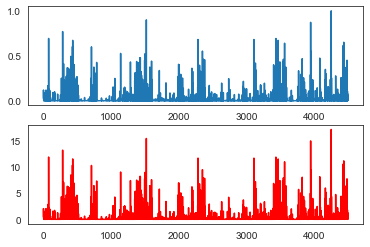

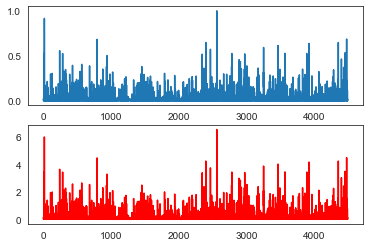

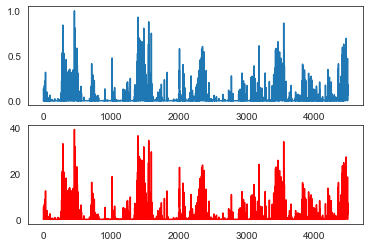

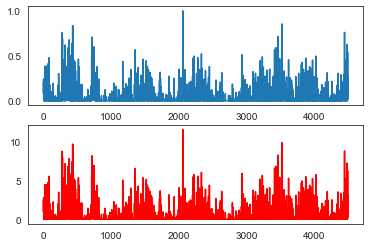

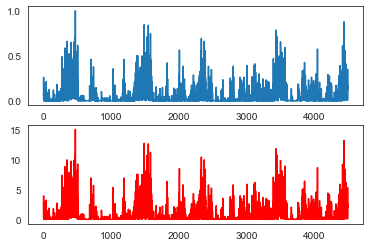

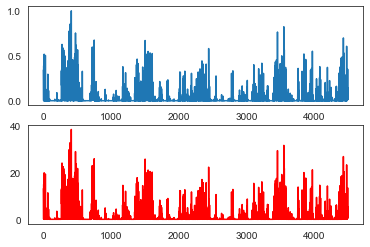

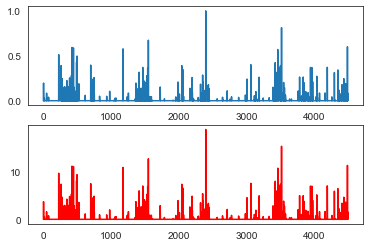

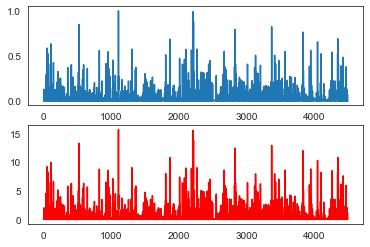

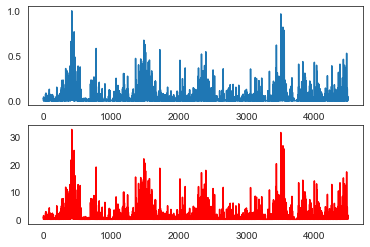

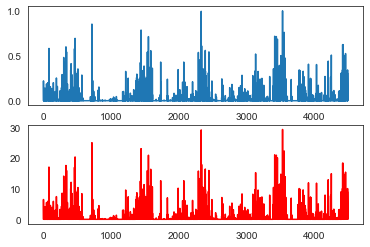

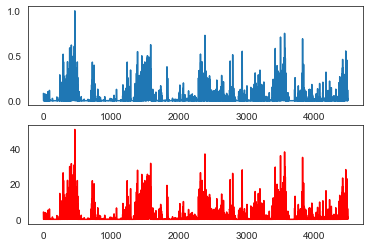

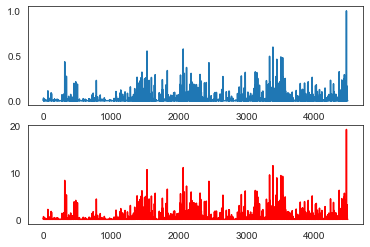

KeyboardInterrupt: 

In [244]:
for i,dff in enumerate(dfs):
    fig,(ax1,ax2) = plt.subplots(2,sharex=False,sharey=False)
    ax1.plot(dff)
    ax2.plot(axons[i],c='red')
    plt.show()
    plt.close()

In [28]:
sns.heatmap(list(df[df.up_mod=='yes'].ave_axon))
plt.axvline(20)

AttributeError: 'numpy.ndarray' object has no attribute 'up_mod'

# actually run this

# find up-modulated units

In [405]:
up_mod = []
down_mod = []
framebefore = 30
frameafter = 30
epochs_all = []
for axon in dfs:
    epochs = []
    for t in up_move[1:-1]:
        #time_axon = t_axons[t]
        a = t-framebefore
        b = t+frameafter
        #fig,(ax1,ax2) = plt.subplots(2)
        #base = axon[a:t]
        #ep = axon[t:b]
        #df = (ep-base)/base
        epoch = axon[a:b]
        #epoch = df
        epochs.append(epoch)
    mn = np.mean(epochs,axis=0)
    #for ugh in epochs:
    #    ax1.plot(ugh)
    md_b=np.median(mn[:framebefore])
    #df = (mn-md_b)/md_b
    #mn_ = np.mean(df[:20])+(2.5*np.std(df[:20]))
    epochs_all.append(list(mn))
    
    meanbinfr_b = mn[:framebefore]
    mfrb_ser = pd.Series(meanbinfr_b)        
    rolave_mfrb = mfrb_ser.rolling(5).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
    rolave_mfrb = np.array(rolave_mfrb.dropna())
    #lower,upper = sms.DescrStatsW(rolave_mfrb).tconfint_mean() #fix this
    upper = np.mean(rolave_mfrb) + (2.56*np.std(rolave_mfrb))
    lower = np.mean(rolave_mfrb) - (2.56*np.std(rolave_mfrb))
    
    meanbinfr_e = mn[framebefore:]
    mfr_ser = pd.Series(meanbinfr_e)        
    rolave_mfr = mfr_ser.rolling(5).sum() #takes sum of 100bins, shifts 1bin
    
    mfr_a = np.array(rolave_mfr)
    up = np.where(mfr_a >= upper)[0].tolist()
    down = np.where(mfr_a <= lower)[0].tolist()

    consec_up,na,nao = countlist(up)
    consec_down,na,nao = countlist(down)
    consec_up = np.array(consec_up)
    consec_down = np.array(consec_down)

    if any(consec_up >= 5): #if there are 5 consecutive bins
        ups = 'yes'
        up_mod.append(ups)
    else:
        ups = 'no'
        up_mod.append(ups)

    if any(consec_down >= 5): #if there are 5 consecutive bins
        downs = 'yes'
        down_mod.append(downs)
    else:
        downs = 'no'
        down_mod.append(downs)

In [406]:
axons_df = []
for i,ax in enumerate(dfs):
    axons_df.append(list(ax))

In [407]:
df = pd.DataFrame(data=up_mod,columns=['up_mod'])
#df['up_mod'] = up_mod
df['fluor'] = axons_df
df['up_mod'] = up_mod
df['ave_axon'] = epochs_all

df_up = df[df.up_mod=='yes']
df_noup = df[df.up_mod!='yes']

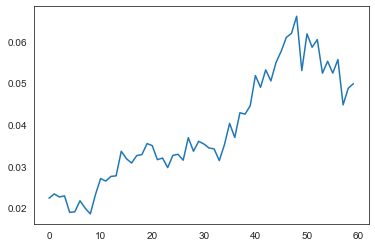

In [408]:
mn_all = np.mean(epochs_all,axis=0)
plt.plot(mn_all)

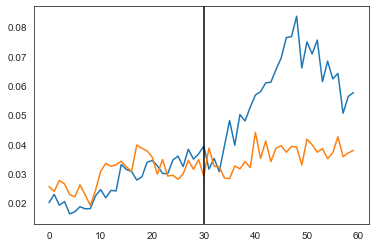

In [410]:
edges=np.arange(0,60,1)
units_up = list(df[df.up_mod=='yes'].ave_axon)
units_notup = list(df[df.up_mod=='no'].ave_axon)
mn_up = np.mean(units_up,axis=0)
mn_all = np.mean(epochs_all,axis=0)
mn_notup = np.mean(units_notup,axis=0)
std_notup = np.std(units_notup,axis=0)
std_up = np.std(units_up,axis=0)
plt.plot(mn_up)
#plt.plot(mn_all)
#plt.errorbar(edges,mn_up,std_up,color='lightblue',label='success')
plt.plot(mn_notup)
plt.axvline(30,c='black')
#plt.savefig(r'Z:\BIOElectricsLab\Katie\motionexpday1_072022\poster_figures\move_onset.svg')

In [315]:
np.shape(df[df.up_mod=='no'])

(56, 3)

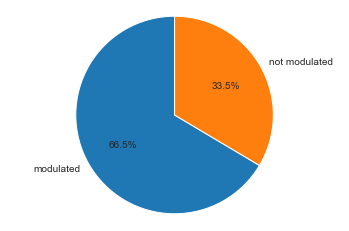

<function matplotlib.pyplot.close(fig=None)>

In [389]:
labels = 'modulated', 'not modulated'
sizes = [111, 56]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(r'Z:\BIOElectricsLab\Katie\motionexpday1_072022\poster_figures\pie_movement.svg')
plt.show()
plt.close

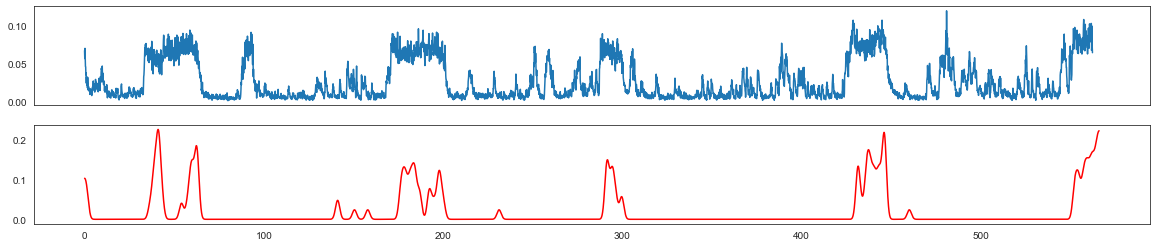

In [295]:
edges = np.arange(0,np.shape(dfs)[1],1)
mns_all = np.mean(dfs,axis=0)
stds_all = np.std(dfs,axis=0)
fig,(ax1,ax2) = plt.subplots(2,figsize=(20, 4),sharex=True)
#ax1.errorbar(edges,mns_all,stds_all,color='lightblue',label='success')
ax1.plot(t_axons,mns_all)
ax2.plot(t_move[1:],smoothed_move,c='red')
plt.savefig(r'Z:\BIOElectricsLab\Katie\motionexpday1_072022\poster_figures\summary.svg')

# plot movement modulation methods

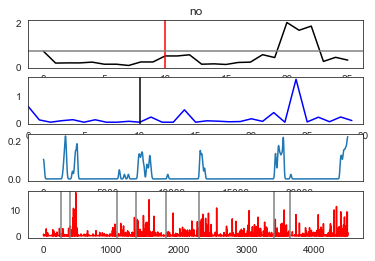

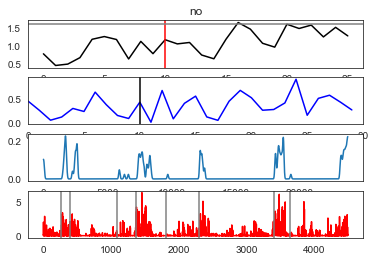

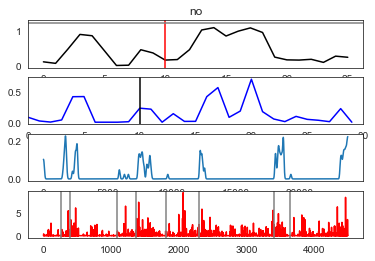

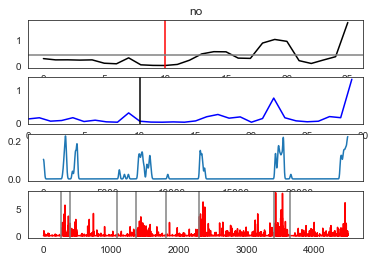

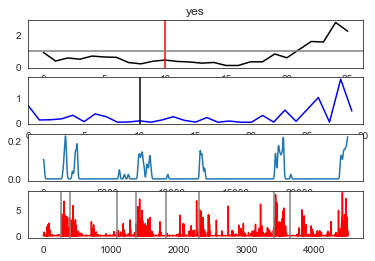

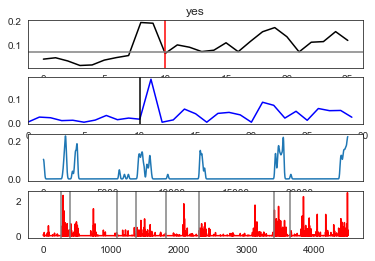

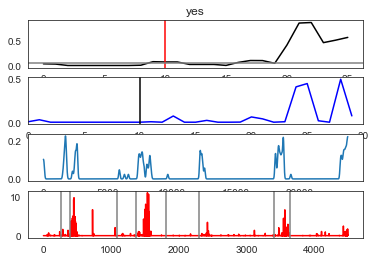

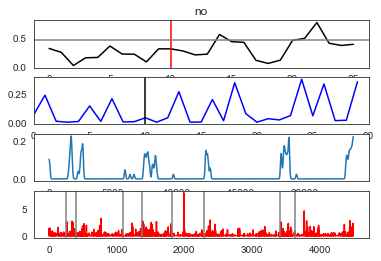

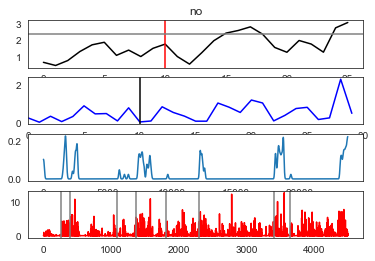

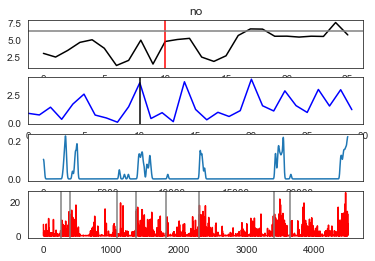

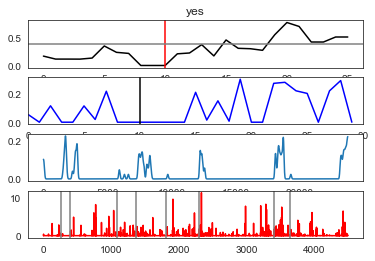

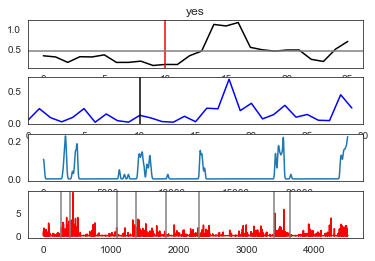

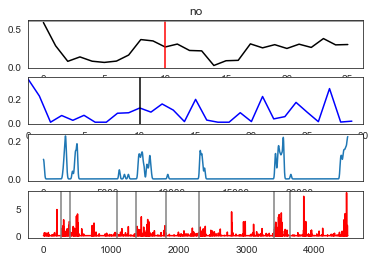

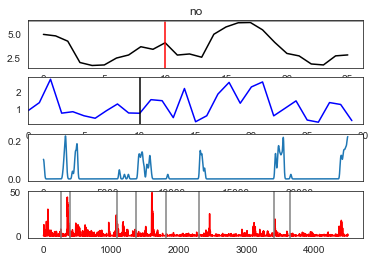

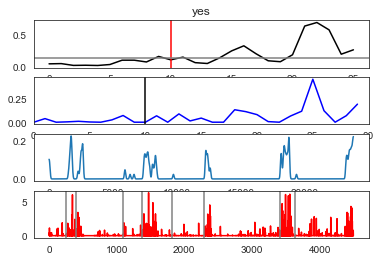

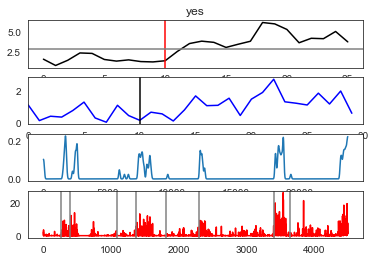

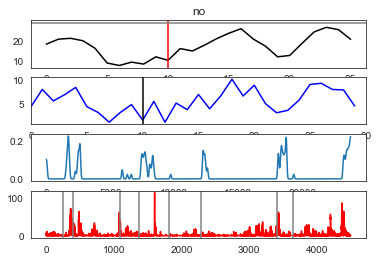

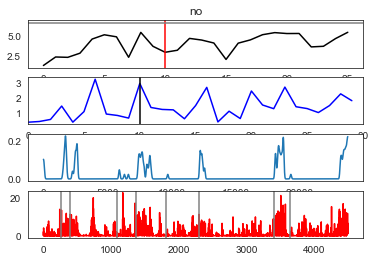

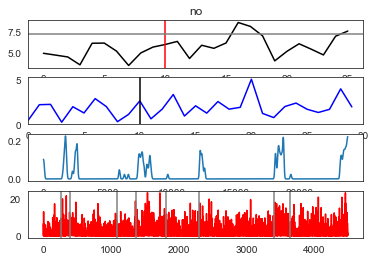

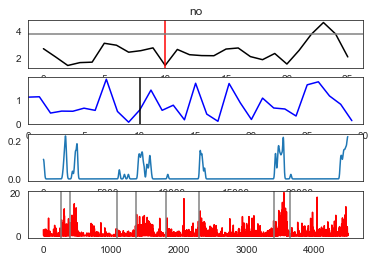

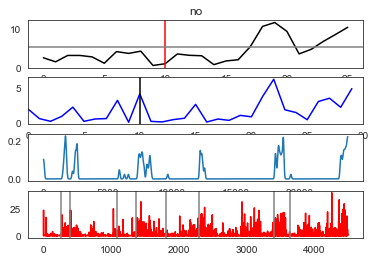

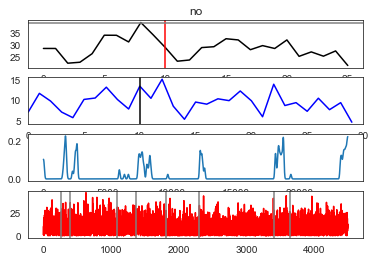

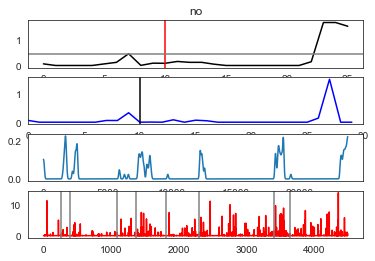

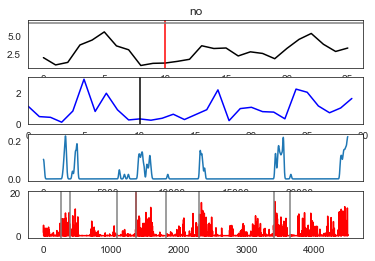

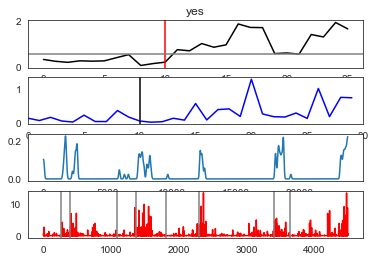

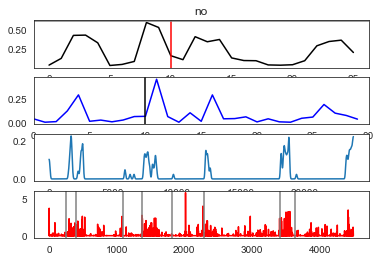

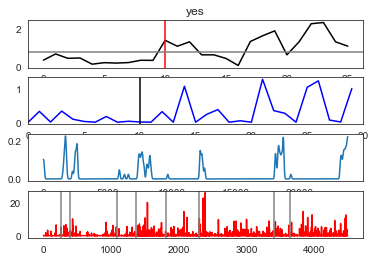

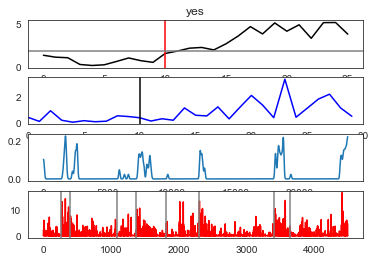

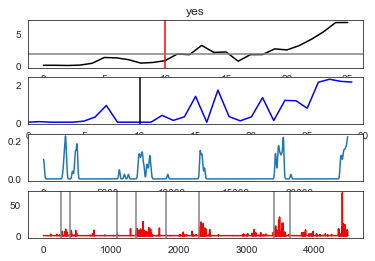

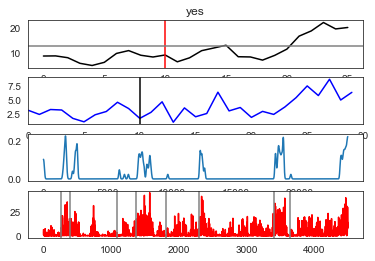

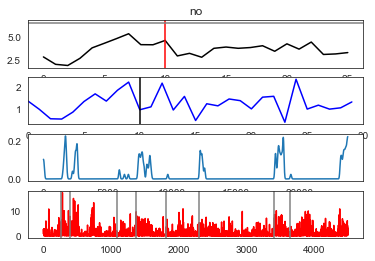

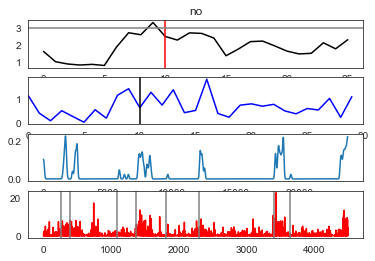

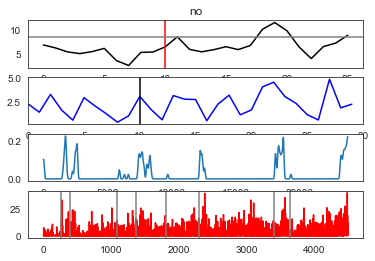

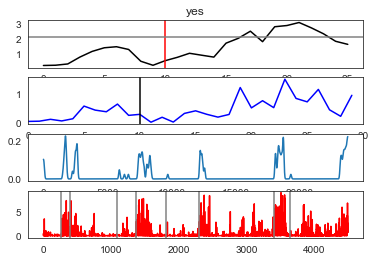

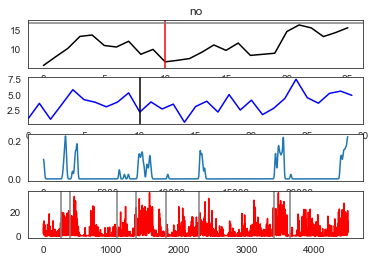

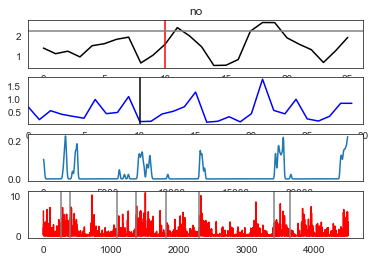

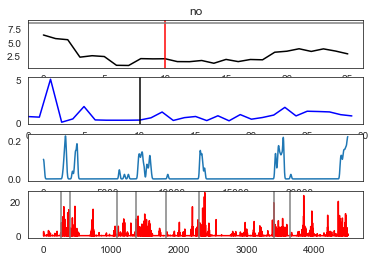

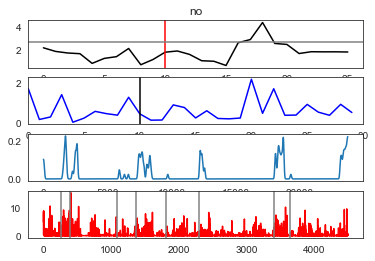

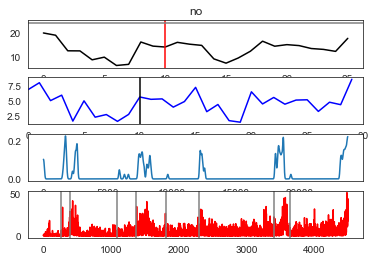

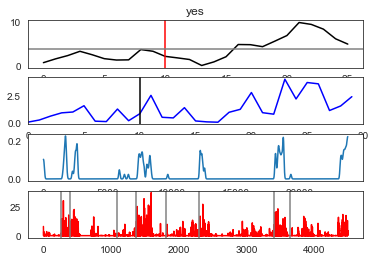

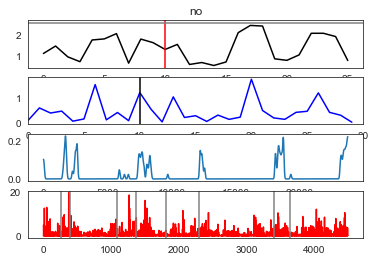

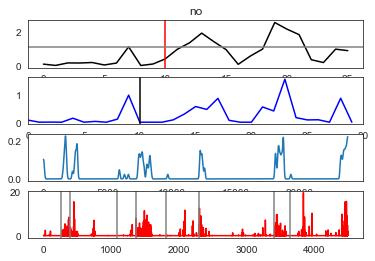

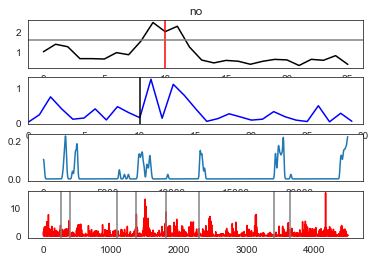

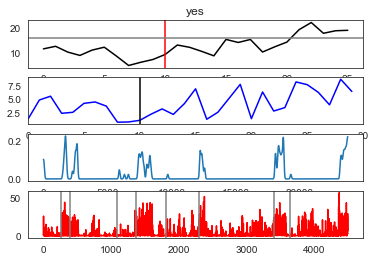

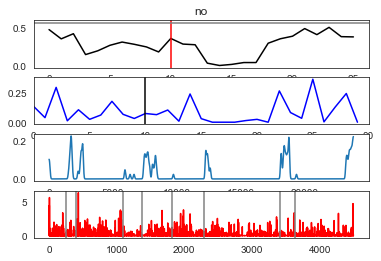

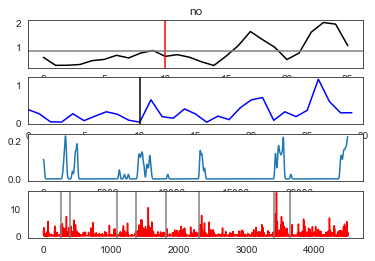

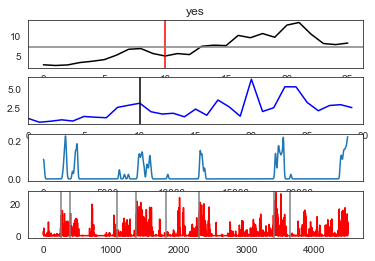

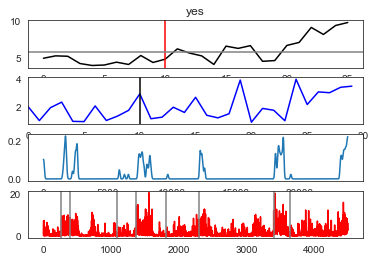

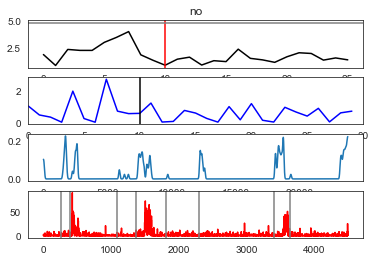

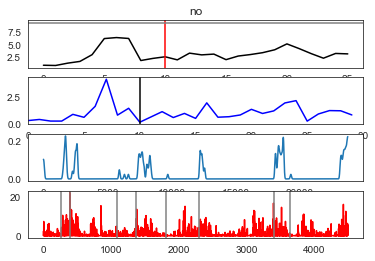

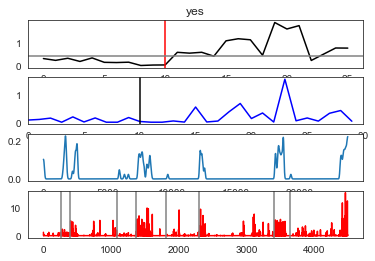

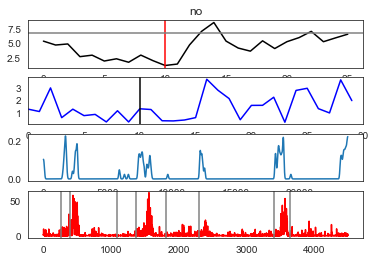

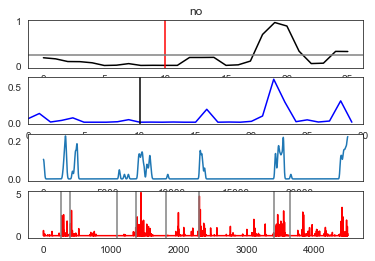

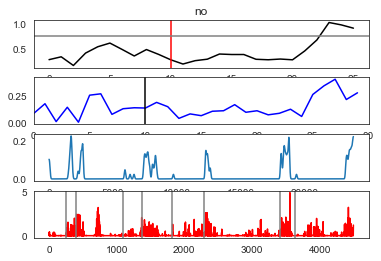

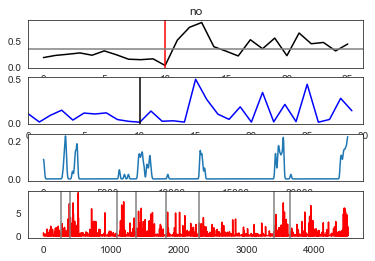

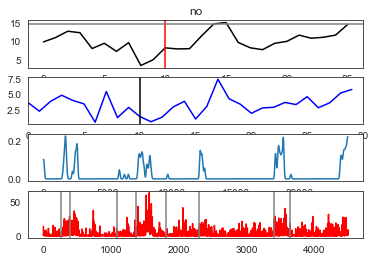

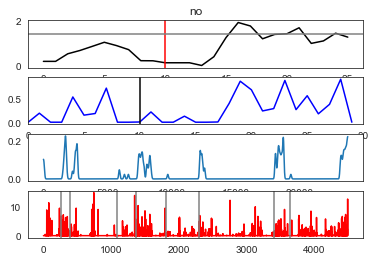

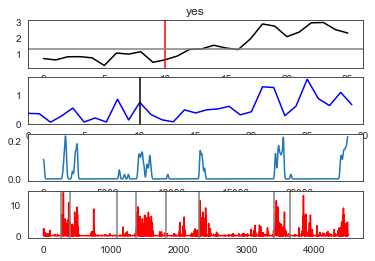

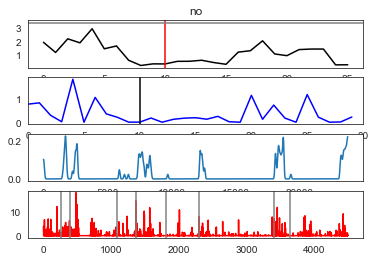

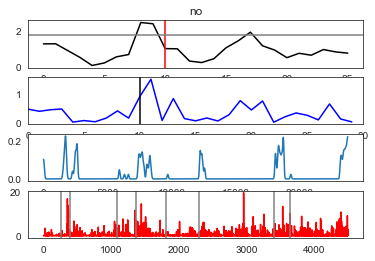

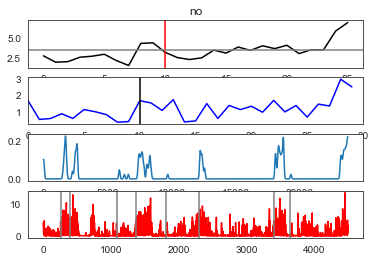

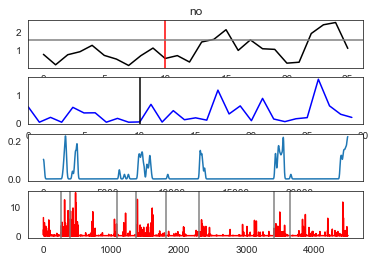

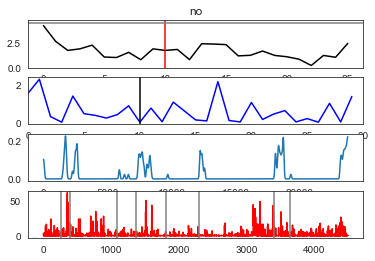

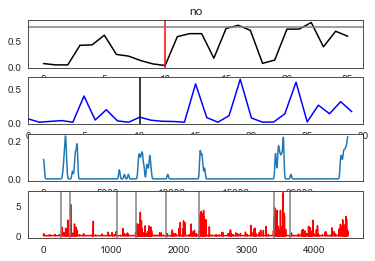

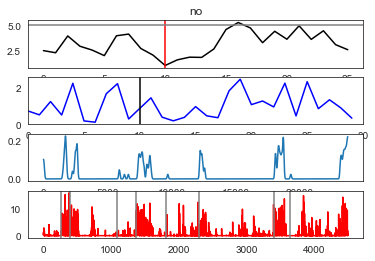

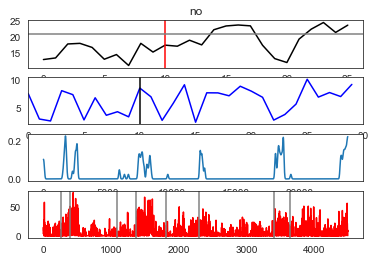

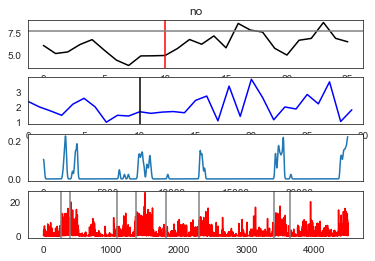

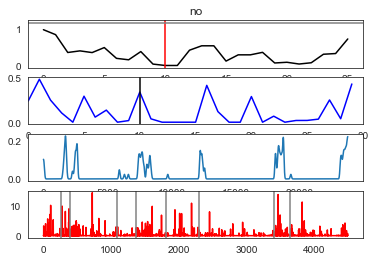

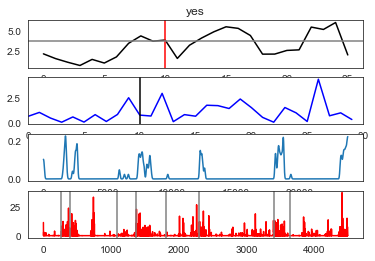

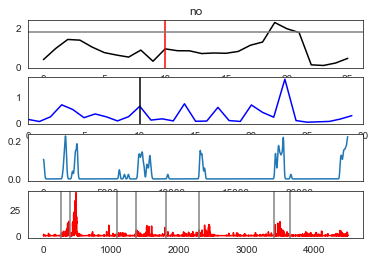

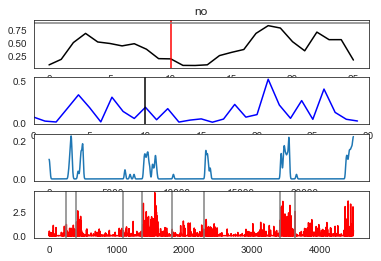

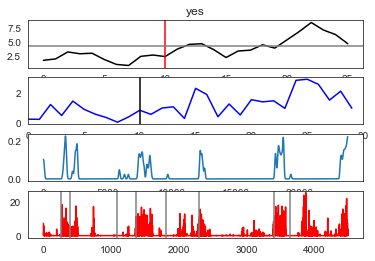

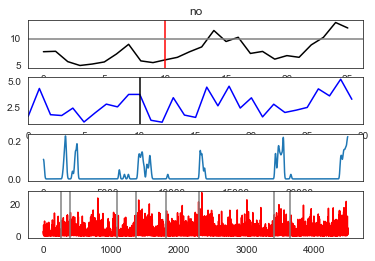

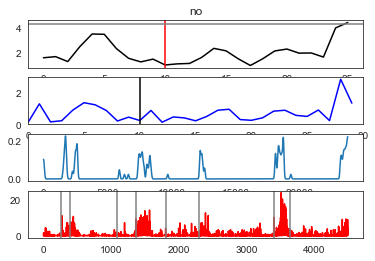

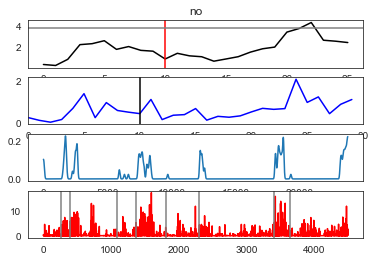

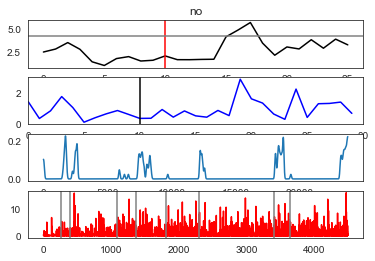

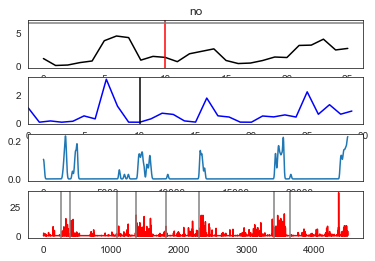

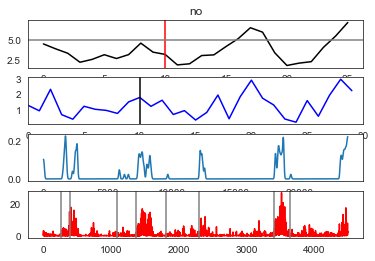

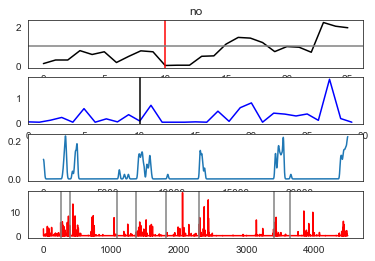

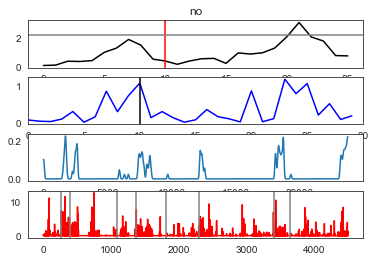

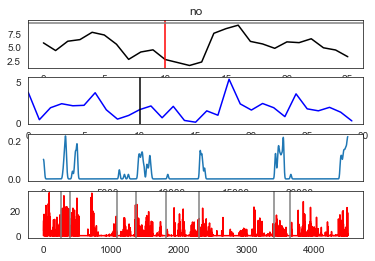

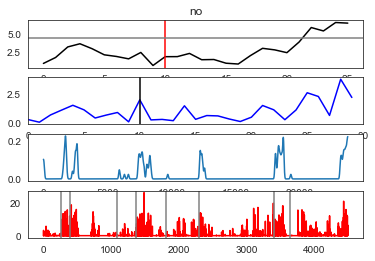

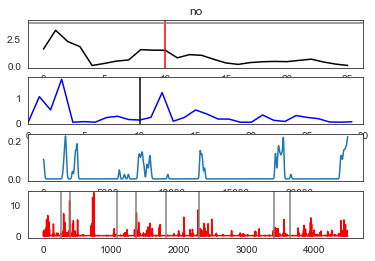

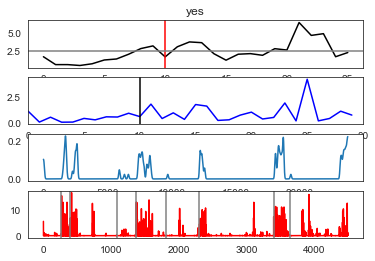

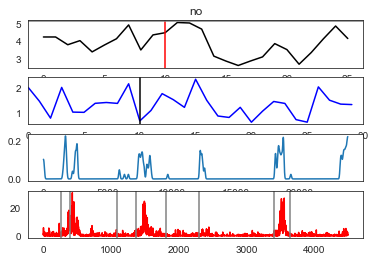

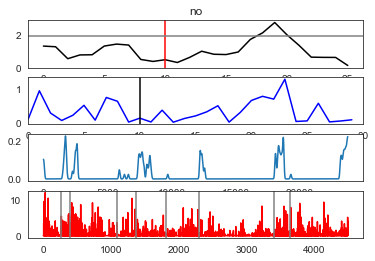

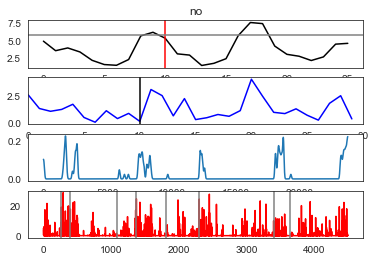

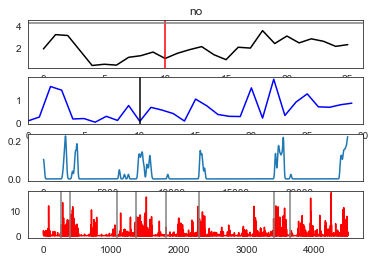

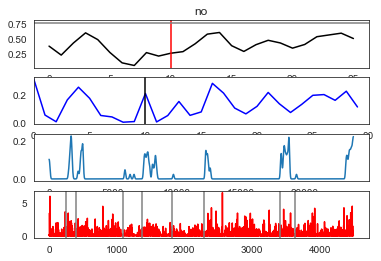

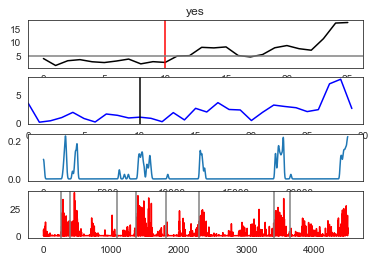

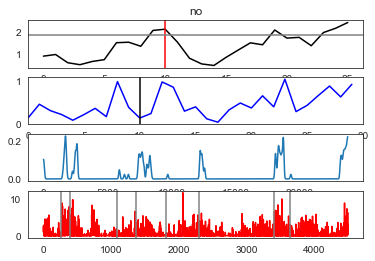

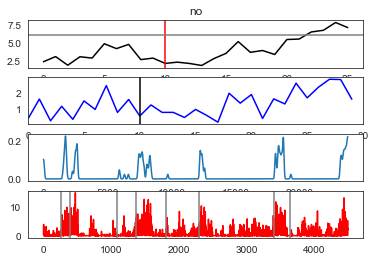

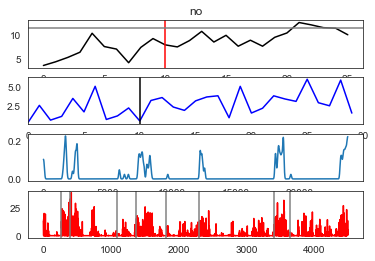

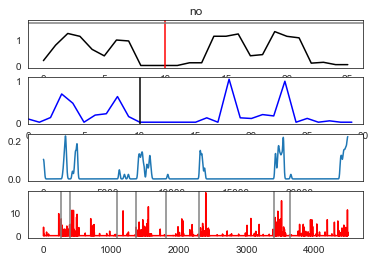

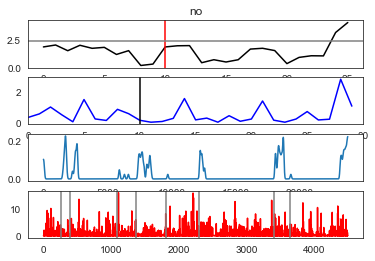

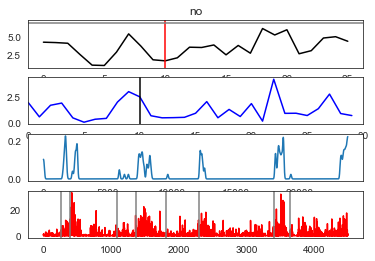

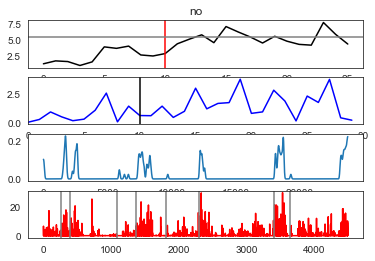

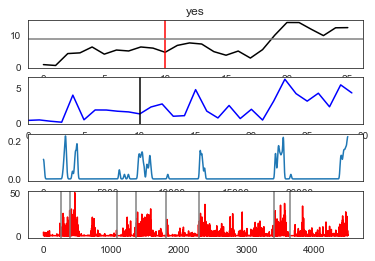

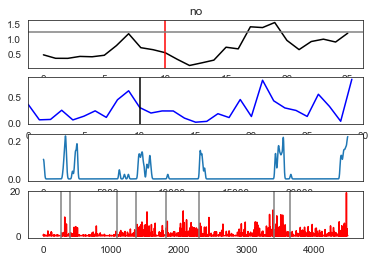

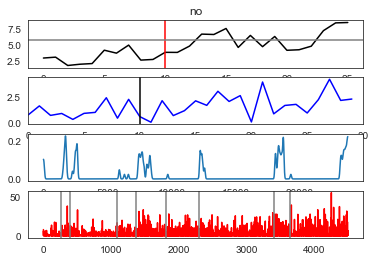

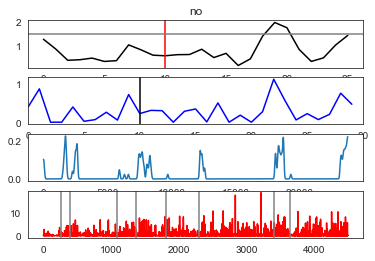

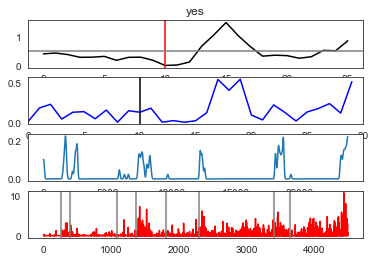

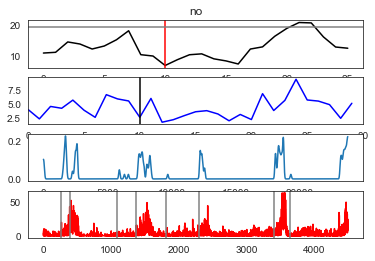

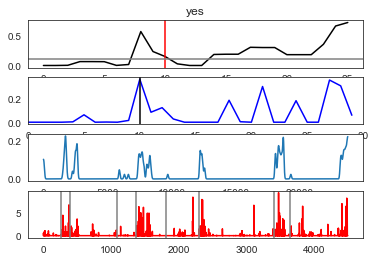

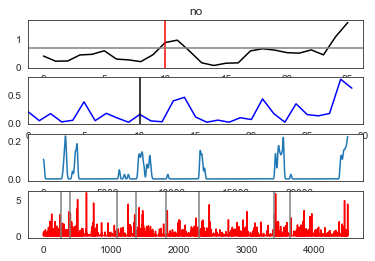

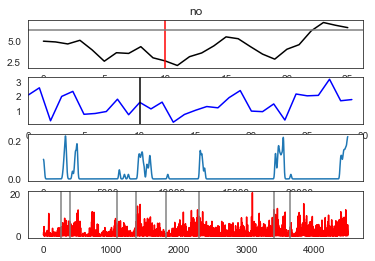

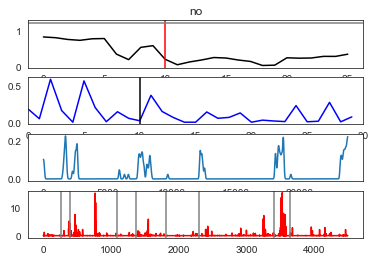

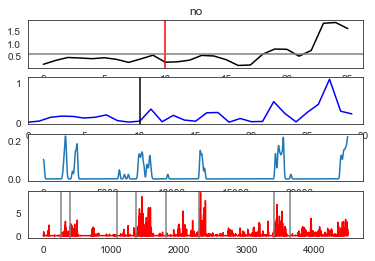

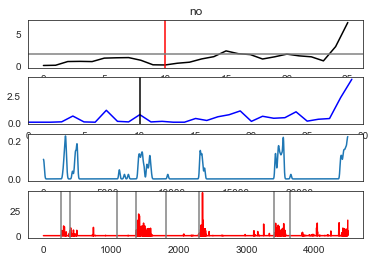

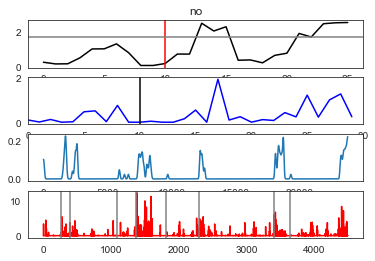

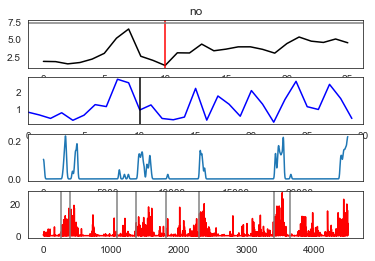

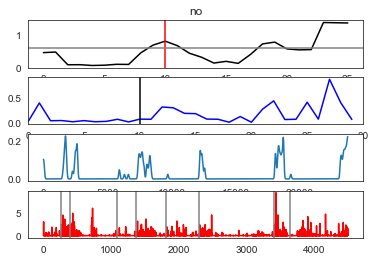

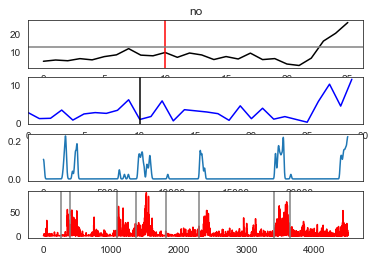

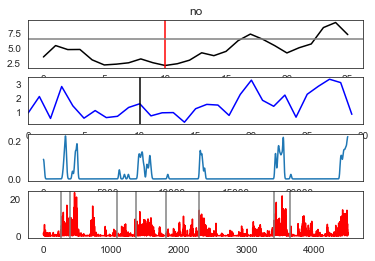

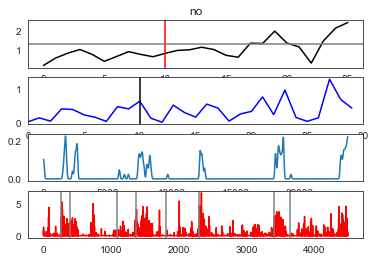

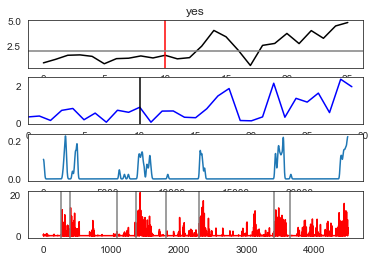

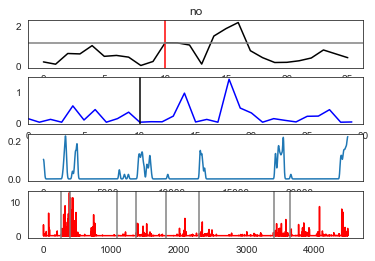

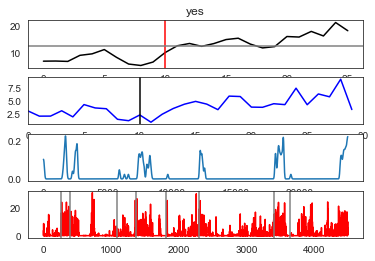

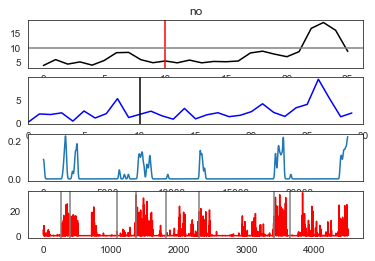

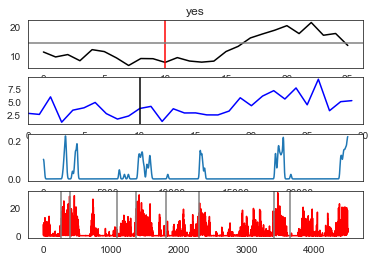

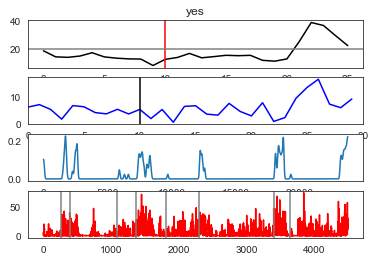

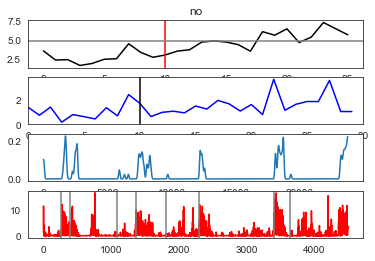

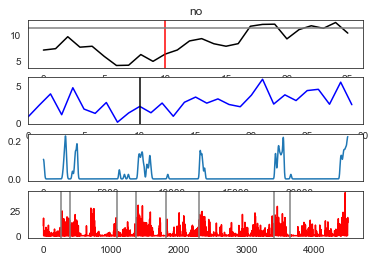

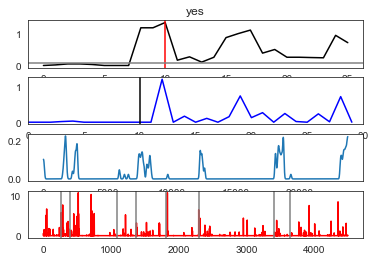

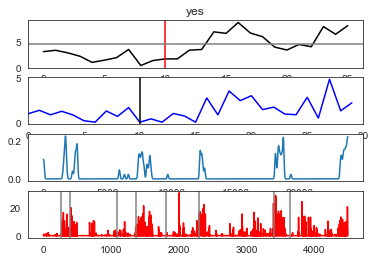

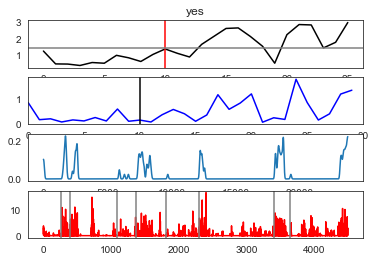

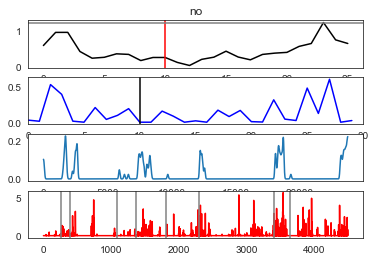

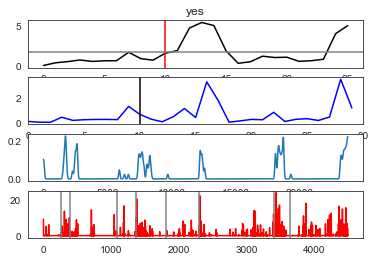

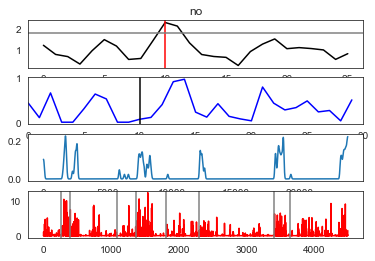

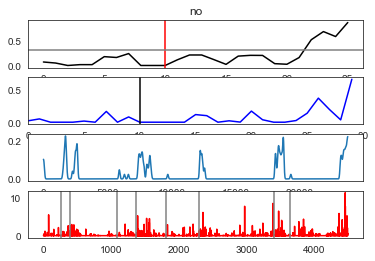

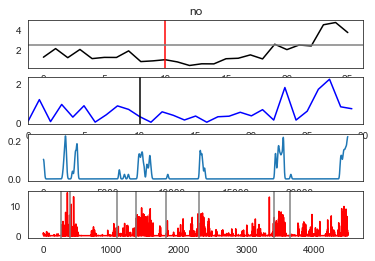

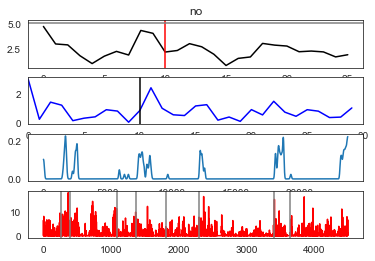

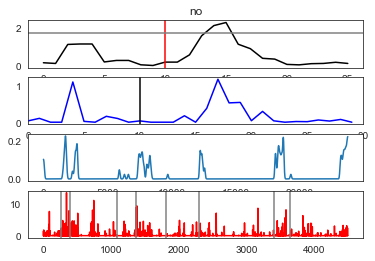

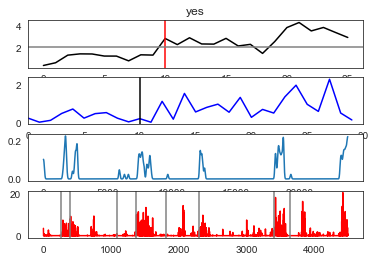

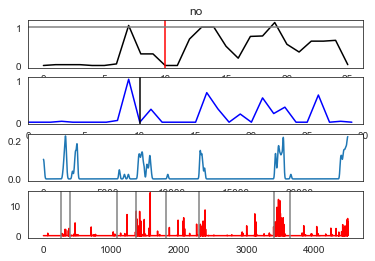

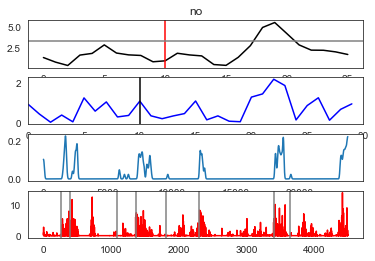

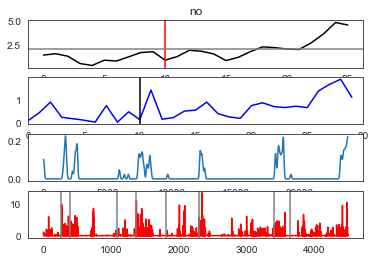

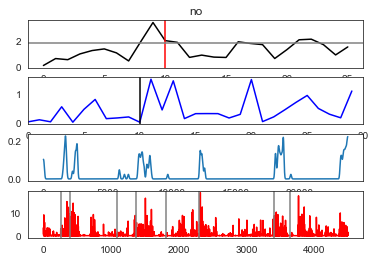

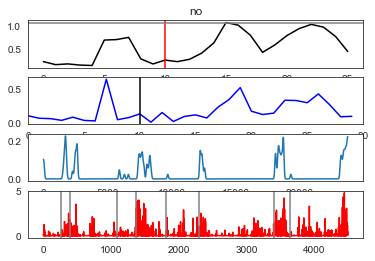

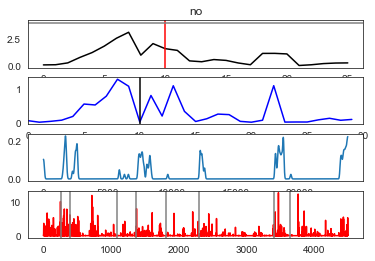

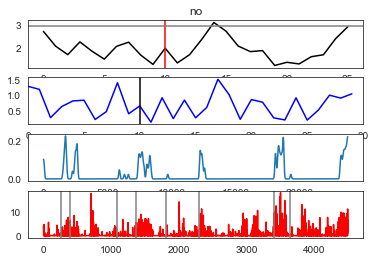

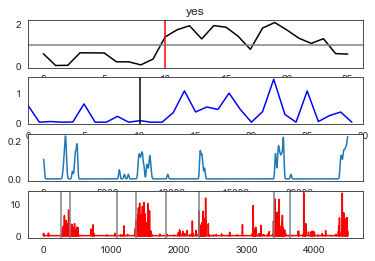

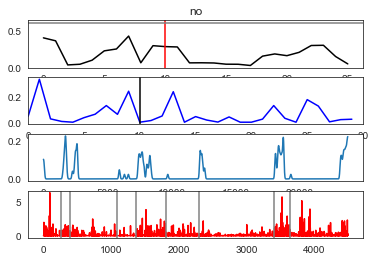

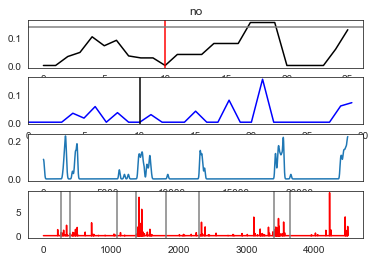

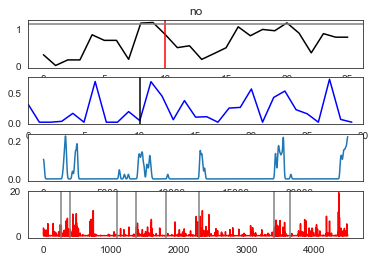

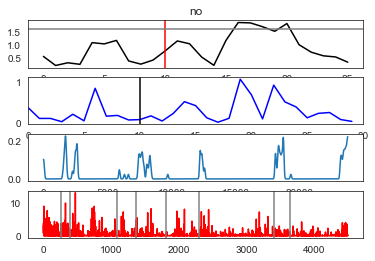

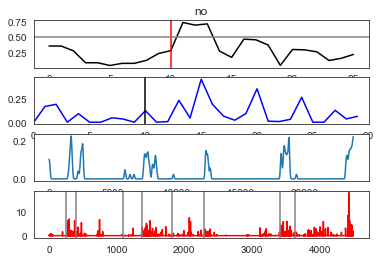

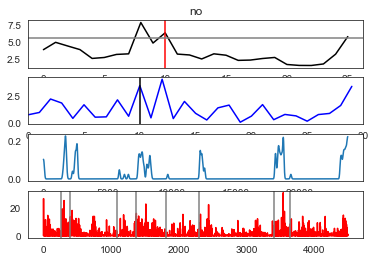

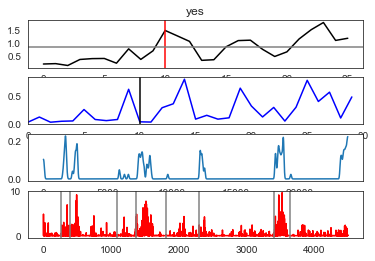

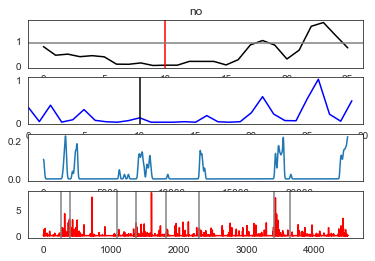

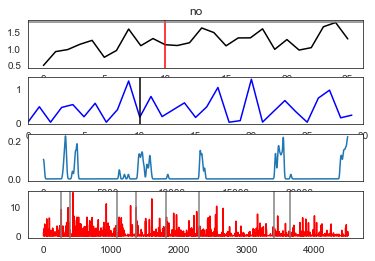

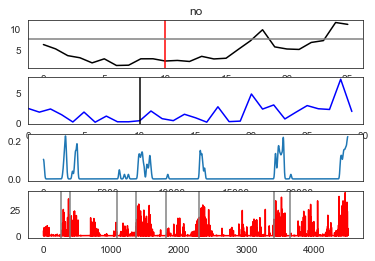

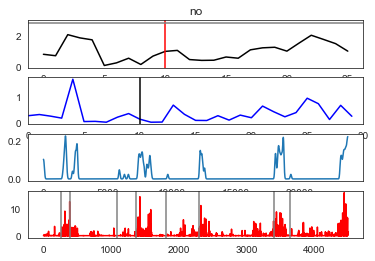

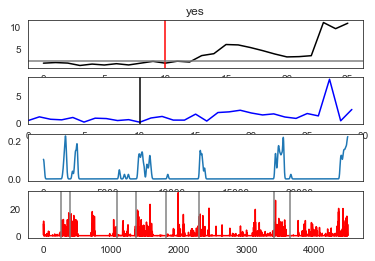

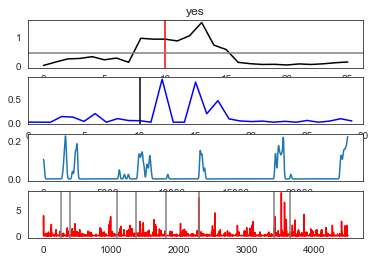

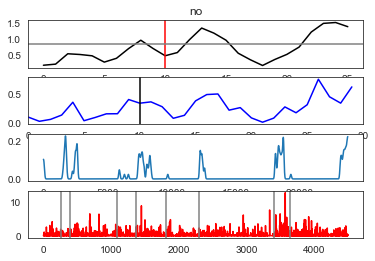

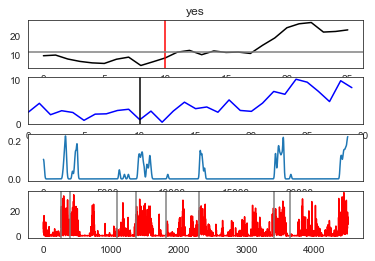

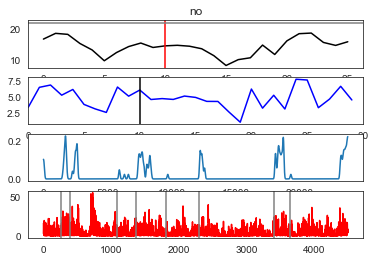

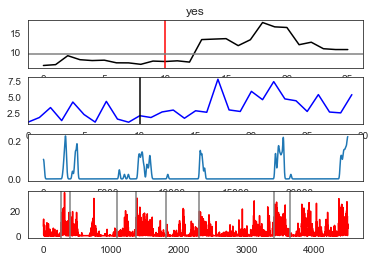

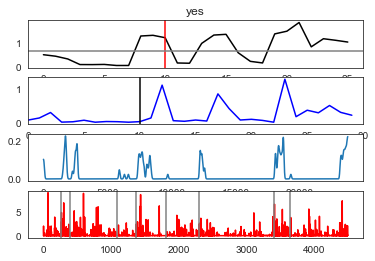

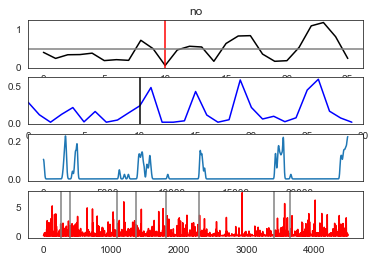

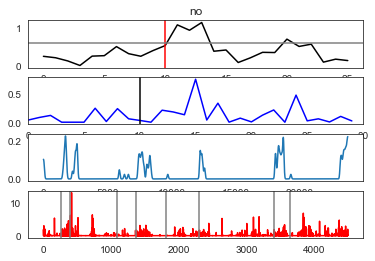

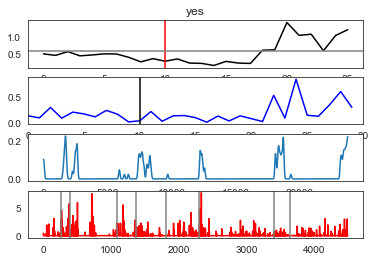

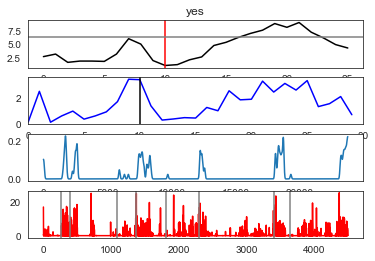

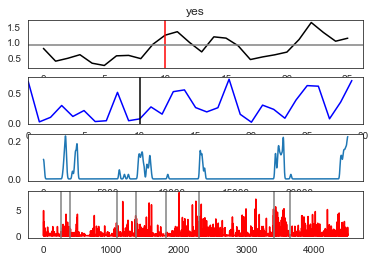

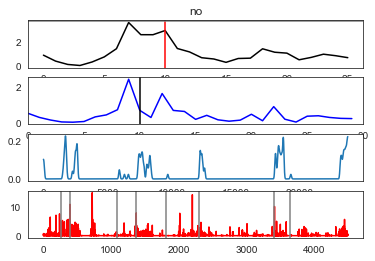

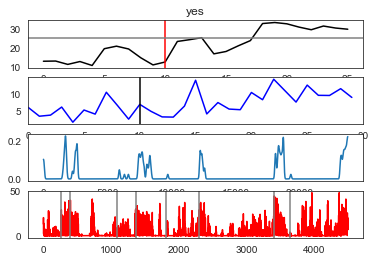

In [404]:
up = []
down = []
framebefore = 10
frameafter = 20
epochs_all = []
for axon in axons:
    epochs = []
    for t in up_move[1:]:
        #time_axon = t_axons[t]
        a = t-framebefore
        b = t+frameafter
        #fig,(ax1,ax2) = plt.subplots(2)
        #base = axon[a:t]
        #ep = axon[t:b]
        #df = (ep-base)/base
        epoch = axon[a:b]
        #epoch = df
        epochs.append(epoch)
    mn = np.mean(epochs,axis=0)
    #for ugh in epochs:
    #    ax1.plot(ugh)
    md_b=np.median(mn[:framebefore])
    df = (mn-md_b)/md_b
    #mn_ = np.mean(df[:20])+(2.5*np.std(df[:20]))
    epochs_all.append(df)
    
    meanbinfr_b = mn[:framebefore]
    mfrb_ser = pd.Series(meanbinfr_b)        
    rolave_mfrb = mfrb_ser.rolling(3).sum() #takes sum of 100bins, shifts 1bin .. 100 bins binned at 1 ms = 100ms summed bins
    rolave_mfrb = np.array(rolave_mfrb.dropna())
    #lower,upper = sms.DescrStatsW(rolave_mfrb).tconfint_mean() #fix this
    upper = np.mean(rolave_mfrb) + (2.56*np.std(rolave_mfrb))
    lower = np.mean(rolave_mfrb) - (2.56*np.std(rolave_mfrb))
    
    meanbinfr_e = mn[framebefore:]
    mfr_ser = pd.Series(meanbinfr_e)        
    rolave_mfr = mfr_ser.rolling(3).sum() #takes sum of 100bins, shifts 1bin
    rolave_mfr = np.array(rolave_mfr.dropna())
    
    mfr_a = np.array(rolave_mfr)
    up = np.where(mfr_a >= upper)[0].tolist()
    down = np.where(mfr_a <= lower)[0].tolist()

    consec_up,na,nao = countlist(up)
    consec_down,na,nao = countlist(down)
    consec_up = np.array(consec_up)
    consec_down = np.array(consec_down)

    if any(consec_up >= 5): #if there are 5 consecutive bins
        ups = 'yes'
        up.append(ups)
    else:
        ups = 'no'
        up.append(ups)

    if any(consec_down >= 5): #if there are 5 consecutive bins
        downs = 'yes'
        down.append(downs)
    else:
        downs = 'no'
        down.append(downs)
    
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,squeeze=True)
    f = list(rolave_mfrb)
    g = list(rolave_mfr)
    f.extend(g)
    ax1.plot(f,c='black')
    ax1.axvline(framebefore,c='red')
    #ax1.plot(rolave_mfr,c='blue')
    ax1.axhline(upper,c='gray')
    ax2.plot(mn,c='blue')
    #ax2.plot(mn,c='gray')
    ax2.set_xlim(0,framebefore+frameafter)
    #ax1.axhline(mn_,c='black')
    ax3.plot(smoothed_move)
    ax4.plot(axon,'red')
    for num in up_move[1:]:
        ax4.axvline(num,c='gray')
    ax2.axvline(framebefore,c='black')
    #ax2.axvline(50,c='black')
    ax1.set_title(str(ups))
    plt.show()
    plt.close()    

In [396]:
np.shape(f)

(18,)

In [395]:
np.shape(g)

(38,)

In [397]:
f.extend(g)

In [398]:
np.shape(f)

(56,)

In [370]:
list(rolave_mfrb)

[1.1034857779741287,
 1.3566536009311676,
 1.237477671355009,
 0.6625781022012234,
 0.3352418877184391,
 0.30325301736593246,
 0.1294296495616436,
 0.3845515288412571,
 1.0719177164137363,
 1.1195678412914276,
 0.7868403196334839,
 0.16512101143598557,
 0.1747978776693344,
 0.1747978776693344,
 0.13552165776491165,
 0.026370659470558167,
 0.026370659470558167,
 0.03936821222305298]

In [371]:
list(rolave_mfr)

[0.22416825592517853,
 0.22416825592517853,
 0.5392559766769409,
 0.5392559766769409,
 0.6003040000796318,
 0.10582060739398003,
 0.12506721913814545,
 0.09265139885246754,
 0.1978724431246519,
 0.21475373022258282,
 0.6051977016031742,
 0.4552040733397007,
 2.2926412522792816,
 1.8834470575675368,
 2.09621377941221,
 0.24401186127215624,
 0.461687495931983,
 0.32096281461417675,
 0.45318760722875595,
 1.5553435757756233,
 1.8001125901937485,
 1.6553937373682857,
 1.205711322836578,
 0.9526369525119662,
 0.9437678530812263,
 0.153667114675045,
 0.08993043005466461,
 0.17373571544885635,
 0.25789815932512283,
 0.5603765323758125,
 0.8698243349790573,
 0.6957314610481262,
 0.5159833207726479,
 0.18831785023212433,
 0.37116794288158417,
 0.35711487382650375,
 0.38244306296110153,
 0.1995929703116417]

In [390]:
f=f.extend(g)

AttributeError: 'NoneType' object has no attribute 'extend'

In [369]:
np.shape(f)

()